# Question 4
This exercise utilizes the data set *Country.sav*, which can be downloaded from this site: 
http://edhd.bgsu.edu/amm/datasets.html

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab 
from scipy import stats
import seaborn as sb
import statsmodels.api as sm
import numbers
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE

In [80]:
dataset = pd.read_excel('Country.xlsx', header=0)

In [81]:
# First take a random sample of 100.
df = dataset.sample(n=100, random_state=123)
df.dtypes

country      object
pop92       float64
urban       float64
gdp           int64
lifeexpm      int64
lifeexpf      int64
birthrat    float64
deathrat    float64
infmr       float64
fertrate    float64
region        int64
develop       int64
radio       float64
phone       float64
hospbed     float64
docs        float64
sequence      int64
dtype: object

In [82]:
df.head()

,country,pop92,urban,gdp,lifeexpm,lifeexpf,birthrat,deathrat,infmr,fertrate,region,develop,radio,phone,hospbed,docs,sequence
4,Malawi,9.605,15.0,200,48,51,52.0,18.0,136.0,6.9,1,1,23.255814,0.568182,15.948963,0.369085,5
94,Saudi Arabia,16.900,78.0,5800,65,68,38.0,7.0,69.0,7.1,13,1,30.303030,7.692308,24.630542,11.737089,95
63,Uruguay,3.121,86.0,2935,69,76,17.0,10.0,22.0,2.5,8,1,100.000000,17.241379,78.740157,29.325513,64
95,Syria,13.730,50.0,2300,65,67,44.0,7.0,45.0,6.3,13,1,24.390244,5.882353,11.904762,7.423905,96
42,Cuba,10.846,72.0,1580,74,79,18.0,7.0,12.0,1.7,6,1,33.333333,5.263158,70.921986,33.003300,43


## Data Preperation

In [84]:
# Dropping missing values rows, because regression requires that we drop nulls
df.dropna(inplace=True)

In [86]:
metric_vars = ['pop92', 'urban', 'gdp', 'lifeexpm', 'lifeexpf', 'birthrat', 'deathrat', 'infmr', 'fertrate',
               'radio', 'phone', 'hospbed', 'docs', 'sequence']
cat_vars = ['country', 'region', 'develop']

In [97]:
# Scale scalar variables
scaler = MinMaxScaler()
df[[*metric_vars]] = scaler.fit_transform(df[[*metric_vars]])
df.head()

/Users/req89250/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,country,pop92,urban,gdp,lifeexpm,lifeexpf,birthrat,deathrat,infmr,fertrate,region,develop,radio,phone,hospbed,docs,sequence
4,Malawi,0.007585,0.105263,0.003707,0.236842,0.238095,1.000000,0.80,0.82500,0.830769,1,1,0.220377,0.005183,0.101227,0.004238,0.033333
94,Saudi Arabia,0.013826,0.768421,0.263207,0.684211,0.642857,0.666667,0.25,0.40625,0.861538,13,1,0.291967,0.083633,0.166694,0.270278,0.783333
63,Uruguay,0.002038,0.852632,0.130445,0.789474,0.833333,0.166667,0.40,0.11250,0.153846,8,1,1.000000,0.188785,0.574730,0.681891,0.525000
95,Syria,0.011114,0.473684,0.101019,0.684211,0.619048,0.809524,0.25,0.25625,0.738462,13,1,0.231901,0.063702,0.070730,0.169338,0.791667
42,Cuba,0.008647,0.705263,0.067655,0.921053,0.904762,0.190476,0.25,0.05000,0.030769,6,1,0.322751,0.056884,0.515774,0.767960,0.350000


In [98]:
# Encode categorical variables
df = pd.get_dummies(df, columns=[*cat_vars])
df.head()

,pop92,urban,gdp,lifeexpm,lifeexpf,birthrat,deathrat,infmr,fertrate,radio,...,region_11,region_12,region_13,region_14,region_15,region_16,region_17,region_18,develop_0,develop_1
4,0.007585,0.105263,0.003707,0.236842,0.238095,1.000000,0.80,0.82500,0.830769,0.220377,...,0,0,0,0,0,0,0,0,0,1
94,0.013826,0.768421,0.263207,0.684211,0.642857,0.666667,0.25,0.40625,0.861538,0.291967,...,0,0,1,0,0,0,0,0,0,1
63,0.002038,0.852632,0.130445,0.789474,0.833333,0.166667,0.40,0.11250,0.153846,1.000000,...,0,0,0,0,0,0,0,0,0,1
95,0.011114,0.473684,0.101019,0.684211,0.619048,0.809524,0.25,0.25625,0.738462,0.231901,...,0,0,1,0,0,0,0,0,0,1
42,0.008647,0.705263,0.067655,0.921053,0.904762,0.190476,0.25,0.05000,0.030769,0.322751,...,0,0,0,0,0,0,0,0,0,1


## A. Regress female life expentancy

In [99]:
# use 7 predictor variables (i.e., percent urban population, GDP, birthrate, number of hospital beds, 
# number of doctors, number of radios, and number of telephones)
features = ['urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone']
x = df[[*features]]
y = df[['lifeexpf']]

In [104]:
# Train test split for evaluation later
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [105]:
model = LinearRegression().fit(x_train, y_train)

In [106]:
r_sq = model.score(x_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.8061073217967796


In [108]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [0.75005196]
slope: [[ 0.14057073  0.0329062  -0.49883329 -0.06706283  0.1785829   0.12528468
  -0.07868383]]


## B. Regression Performance

In [109]:
y_pred = model.predict(x_test)

In [110]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.14759055747867517
Mean Squared Error: 0.03334085172348057
Root Mean Squared Error: 0.18259477463356003


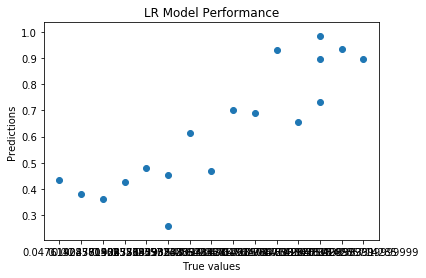

In [111]:
plt.scatter(y_test,y_pred)
plt.title('LR Model Performance')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

In [112]:
# Retrain on the entire dataset after you get an estimate for model performance
model = LinearRegression().fit(x, y)

In [113]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [0.67693692]
slope: [[ 0.1943148   0.0412039  -0.45569385 -0.02994266  0.20240773  0.07503108
  -0.04273368]]


In [22]:
# Formula: y = 0.6769 + 0.1943148(urban) +  0.0412039(gdb) + -0.45569385(birthrat) + -0.02994266(hospbed) +
#  0.20240773(docs) + 0.07503108(radio) + -0.04273368(phone)

## C. Stepwise Regression

In [114]:
print(features)
metrics.mean_squared_error(y_test, y_pred)

['urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone']


0.03334085172348057

In [115]:
rfe = RFE(model, 1)
rfe = rfe.fit(x_train, y_train)
rfe.ranking_
feature_elimination = pd.DataFrame(columns=['variable', 'support', 'ranking'])
# print summaries for the selection of attributes
for i in range(len(features)):
    feature_elimination = feature_elimination.append({'variable':features[i], 'support': rfe.support_[i],
                                                      'ranking': rfe.ranking_[i]},ignore_index=True)
feature_elimination

/Users/req89250/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,variable,support,ranking
0,urban,False,2
1,gdp,False,7
2,birthrat,True,1
3,hospbed,False,5
4,docs,False,3
5,radio,False,4
6,phone,False,6


In [116]:
feature_elimination

,variable,support,ranking
0,urban,False,2
1,gdp,False,7
2,birthrat,True,1
3,hospbed,False,5
4,docs,False,3
5,radio,False,4
6,phone,False,6


In [117]:
# Eliminate 1 feature
current_features = list(features)
current_features.remove('gdp')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

['urban', 'birthrat', 'hospbed', 'docs', 'radio', 'phone']
0.03339598244887576


In [118]:
# Eliminate 2 features
current_features = list(features)
current_features.remove('gdp')
current_features.remove('phone')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

['urban', 'birthrat', 'hospbed', 'docs', 'radio']
0.032885434286555285


In [119]:
# Eliminate 3 features
current_features = list(features)
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('hospbed')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

['urban', 'birthrat', 'docs', 'radio']
0.03244817651730519


In [120]:
# Eliminate 4 features
current_features = list(features)
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('hospbed')
current_features.remove('radio')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

print('intercept:', tmodel.intercept_)
print('slope:', tmodel.coef_)

['urban', 'birthrat', 'docs']
0.032240944175489304
intercept: [0.78267382]
slope: [[ 0.16326006 -0.52773093  0.13035906]]


In [121]:
# Eliiminate 5 features
# Eliminate 4 features
current_features = list(features)
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('hospbed')
current_features.remove('radio')
current_features.remove('docs')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

['urban', 'birthrat']
0.03461848195324601


In [122]:
# Eliminate 6 features
# Eliiminate 5 features
# Eliminate 4 features
current_features = list(features)
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('hospbed')
current_features.remove('radio')
current_features.remove('urban')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

['birthrat', 'docs']
0.03714651724428552


## D. Analyzing Other Variables

In [32]:
print(df.columns)

Index(['country', 'pop92', 'urban', 'gdp', 'lifeexpm', 'lifeexpf', 'birthrat',
       'deathrat', 'infmr', 'fertrate', 'region', 'develop', 'radio', 'phone',
       'hospbed', 'docs', 'sequence'],
      dtype='object')


In [33]:
other_metric = ['pop92', 'deathrat', 'infmr', 'fertrate', 'sequence', 'region']

other_cat = ['country', 'region', 'develop']

In [34]:
df.isnull().mean().round(4) * 100

country     0.0
pop92       0.0
urban       0.0
gdp         0.0
lifeexpm    0.0
lifeexpf    0.0
birthrat    0.0
deathrat    0.0
infmr       0.0
fertrate    0.0
region      0.0
develop     0.0
radio       0.0
phone       0.0
hospbed     0.0
docs        0.0
sequence    0.0
dtype: float64

In [35]:
df['pop92'].describe()

count    87.000000
mean      0.029694
std       0.108146
min       0.000000
25%       0.003625
50%       0.008306
75%       0.022492
max       1.000000
Name: pop92, dtype: float64

In [36]:
df['deathrat'].describe()

count    87.000000
mean      0.429885
std       0.228679
min       0.000000
25%       0.250000
50%       0.400000
75%       0.600000
max       1.000000
Name: deathrat, dtype: float64

In [37]:
df['fertrate'].describe()

count    87.000000
mean      0.427763
std       0.304951
min       0.000000
25%       0.100000
50%       0.446154
75%       0.700000
max       1.000000
Name: fertrate, dtype: float64

In [38]:
df['sequence'].describe()

count    87.000000
mean      0.484195
std       0.300670
min       0.000000
25%       0.208333
50%       0.491667
75%       0.729167
max       1.000000
Name: sequence, dtype: float64

In [39]:
df['country'].describe()

count         87
unique        87
top       Bhutan
freq           1
Name: country, dtype: object

In [40]:
df['country'].value_counts()

Bhutan            1
Austria           1
Namibia           1
Mongolia          1
Mauritius         1
Zambia            1
Chad              1
Bangladesh        1
Iraq              1
Jordan            1
Switzerland       1
Rwanda            1
Zaire             1
Brazil            1
Finland           1
Nicaragua         1
Bulgaria          1
Gabon             1
Botswana          1
New Zealand       1
Italy             1
South Korea       1
Cameroon          1
Poland            1
Nepal             1
Kuwait            1
Vietnam           1
Mozambique        1
Singapore         1
Iran              1
                 ..
Australia         1
Japan             1
Spain             1
Netherlands       1
Haiti             1
Bolivia           1
Myanmar           1
Morocco           1
Sri Lanka         1
Angola            1
Panama            1
United Kingdom    1
Burundi           1
Ethiopia          1
Togo              1
Syria             1
Uganda            1
Portugal          1
Honduras          1


In [41]:
df['region'].describe()

count    87.000000
mean      8.252874
std       5.218969
min       1.000000
25%       3.500000
50%       8.000000
75%      12.500000
max      18.000000
Name: region, dtype: float64

In [42]:
df['region'].value_counts()

1     12
8      9
5      7
13     6
12     6
2      6
11     5
7      5
3      4
15     4
10     4
17     4
6      4
16     3
14     3
18     2
4      2
9      1
Name: region, dtype: int64

In [43]:
df.sort_values(by='region').head(10)

,country,pop92,urban,gdp,lifeexpm,lifeexpf,birthrat,deathrat,infmr,fertrate,region,develop,radio,phone,hospbed,docs,sequence
4,Malawi,0.007585,0.105263,0.003707,0.236842,0.238095,1.000000,0.80,0.82500,0.830769,1,1,0.220377,0.005183,0.101227,0.004238,0.033333
1,Ethiopia,0.043059,0.063158,0.000463,0.289474,0.285714,0.833333,0.65,0.68125,0.738462,1,1,0.168831,0.002368,0.000428,0.001984,0.008333
11,Zambia,0.006849,0.463158,0.012048,0.421053,0.428571,0.904762,0.45,0.45625,0.846154,1,1,0.056689,0.013044,0.223430,0.023338,0.091667
6,Mozambique,0.012602,0.147368,0.000000,0.184211,0.190476,0.857143,0.75,0.81250,0.723077,1,1,0.019157,0.004001,0.042415,0.000976,0.050000
2,Kenya,0.021752,0.221053,0.012280,0.552632,0.547619,0.809524,0.30,0.40000,0.938462,1,1,0.153439,0.015362,0.083276,0.027602,0.016667
10,Uganda,0.015953,0.063158,0.008341,0.289474,0.261905,0.976190,0.65,0.54375,0.815385,1,1,0.183318,0.002777,0.073257,0.007302,0.083333
3,Madagascar,0.010144,0.178947,0.003707,0.315789,0.333333,0.880952,0.65,0.55625,0.769231,1,1,0.111111,0.003534,0.113954,0.014240,0.025000
9,Tanzania,0.023144,0.284211,0.006487,0.289474,0.333333,0.952381,0.70,0.61875,0.846154,1,1,0.153439,0.005255,0.044647,0.004831,0.075000
5,Mauritius,0.000293,0.378947,0.101019,0.710526,0.785714,0.214286,0.20,0.11250,0.061538,1,1,0.226002,0.072339,0.188125,0.204925,0.041667
0,Burundi,0.004520,0.031579,0.003707,0.315789,0.333333,0.857143,0.60,0.63750,0.707692,1,1,0.076479,0.000729,0.127383,0.002965,0.000000


In [44]:
df['develop'].describe()

count    87.000000
mean      0.770115
std       0.423198
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: develop, dtype: float64

In [45]:
df['develop'].value_counts()

1    67
0    20
Name: develop, dtype: int64


 Univariate Normality test for pop92


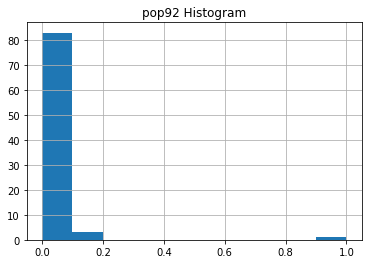

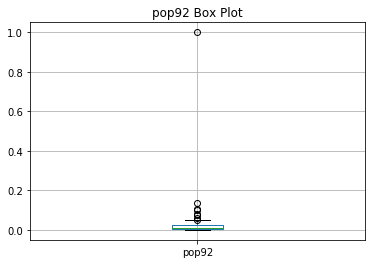

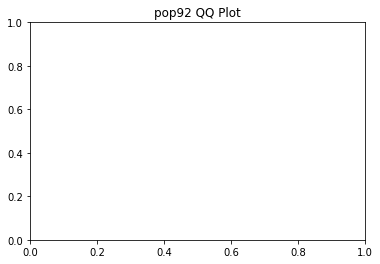

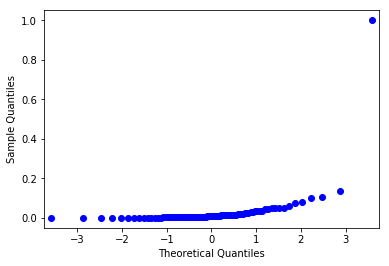


 Univariate Normality test for deathrat


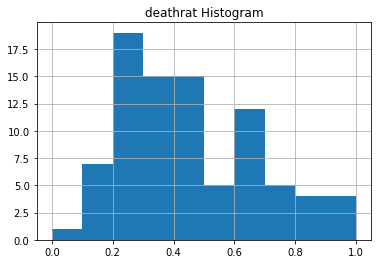

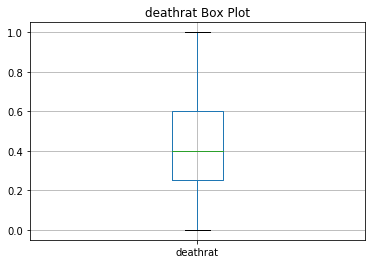

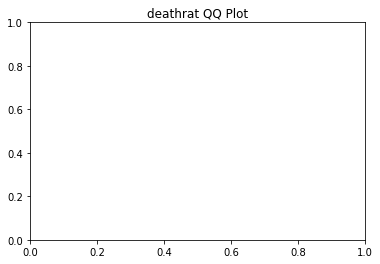

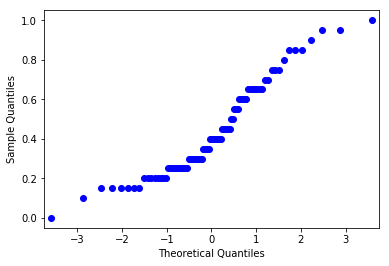


 Univariate Normality test for infmr


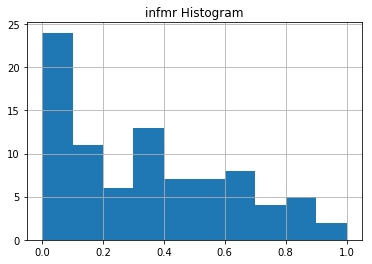

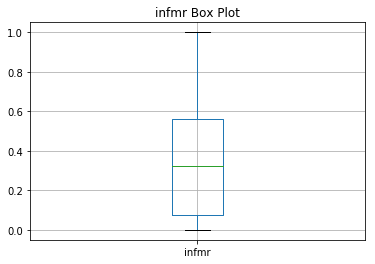

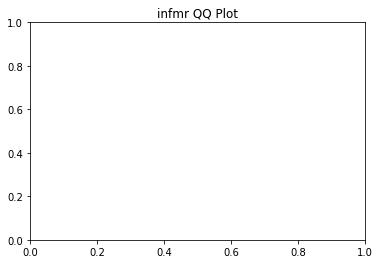

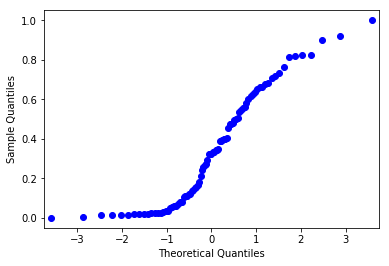


 Univariate Normality test for fertrate


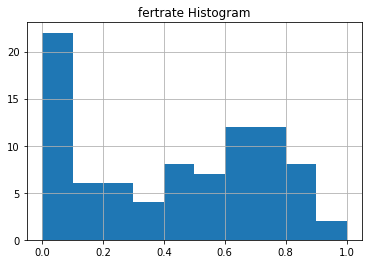

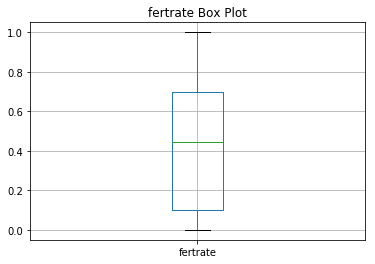

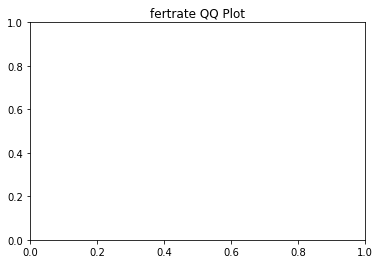

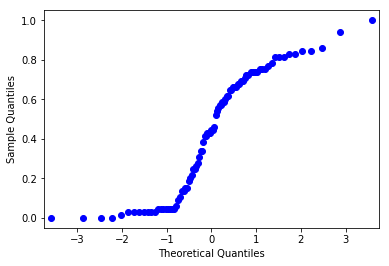


 Univariate Normality test for sequence


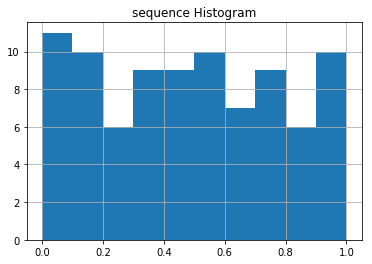

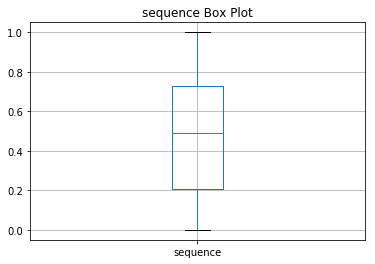

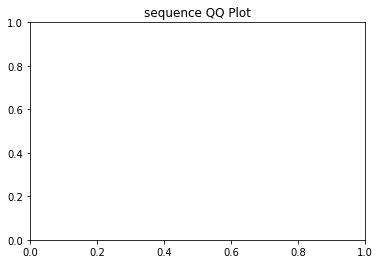

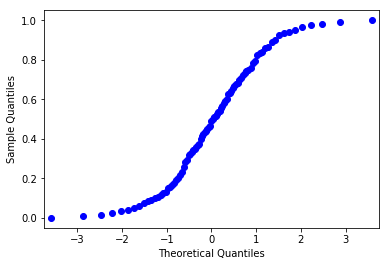


 Univariate Normality test for region


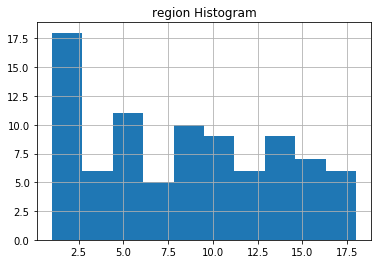

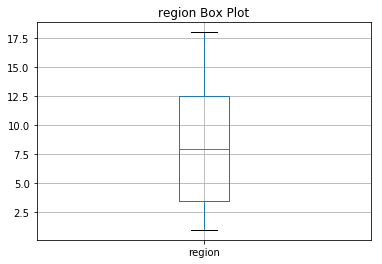

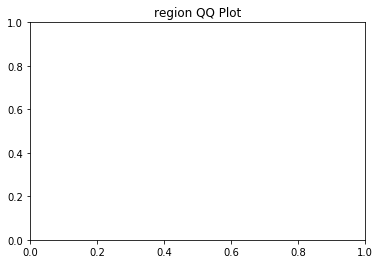

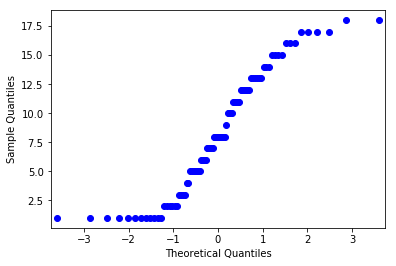

In [46]:
for i in other_metric:
    print('\n Univariate Normality test for {}'.format(i))
    # Histogram
    temp_hist = df.hist(column=i)
    plt.title("{} Histogram".format(i))
    plt.show()
    # Box Plot
    age_box = df.boxplot(column=i)
    plt.title("{} Box Plot".format(i))
    plt.show()
    # Normality (QQ Plot)
    #stats.probplot(df[i], dist="norm", plot=pylab)
    plt.title("{} QQ Plot".format(i))
    plt.show()
    fig = sm.qqplot(df[i], stats.t, distargs=(4,))
    plt.show()

## E. Model Tournament

### Assessing Normality,  and bivariate linearity



 Univariate Profiling: Examining the Shape of Distribution for urban


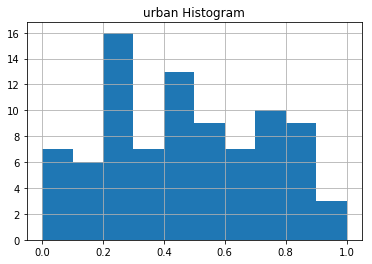

Mean (solid line): 0.4694857834240773
Median(dotted line): 0.46315789473684205


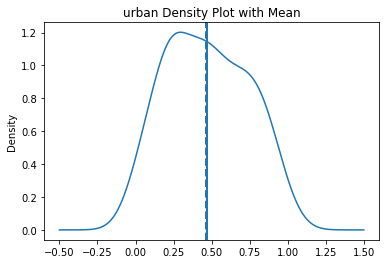

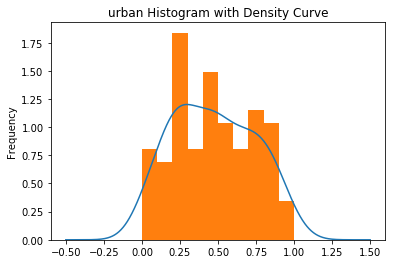

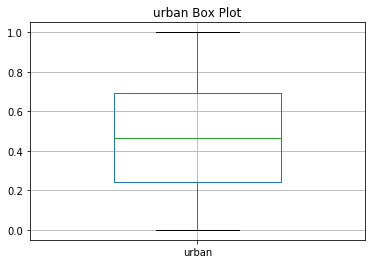

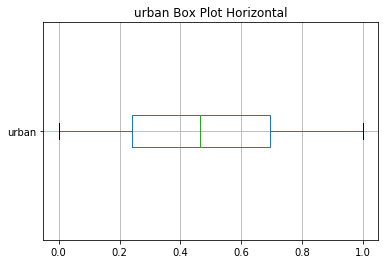

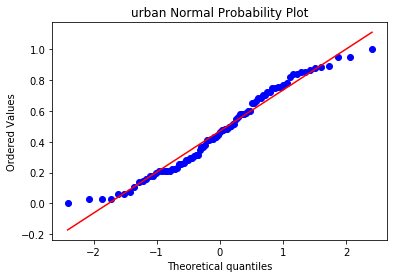



 Univariate Profiling: Examining the Shape of Distribution for gdp


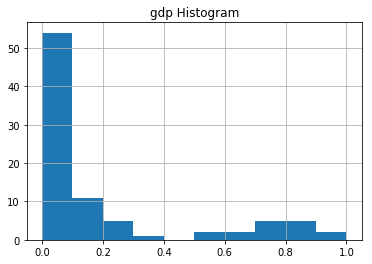

Mean (solid line): 0.19433117083719498
Median(dotted line): 0.04133456904541242


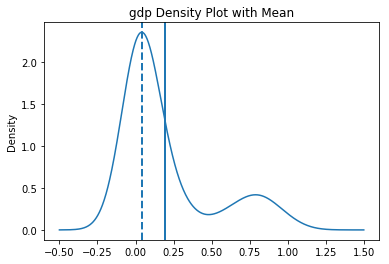

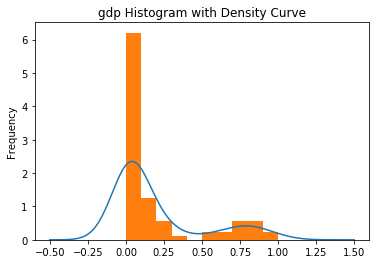

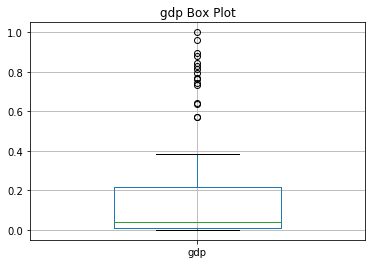

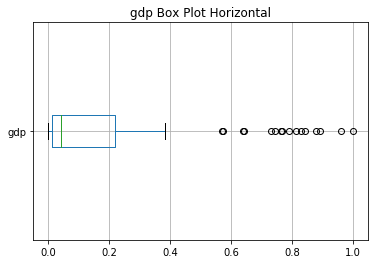

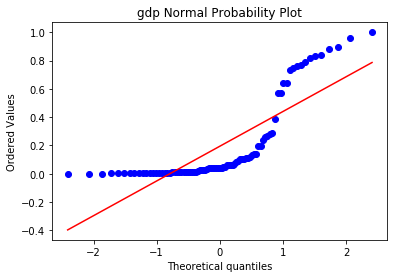



 Univariate Profiling: Examining the Shape of Distribution for birthrat


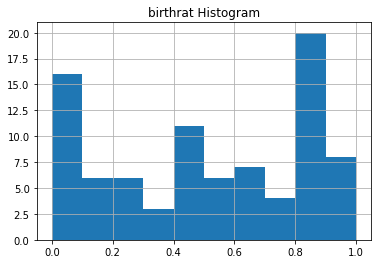

Mean (solid line): 0.5119594964422552
Median(dotted line): 0.5476190476190477


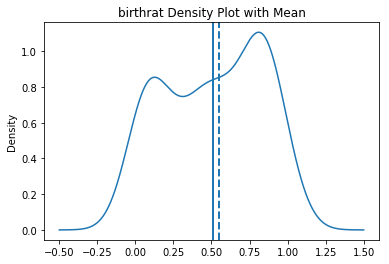

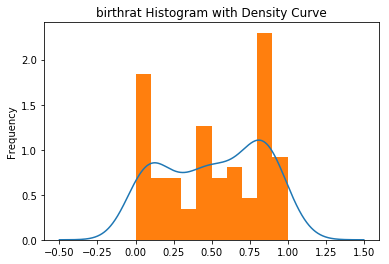

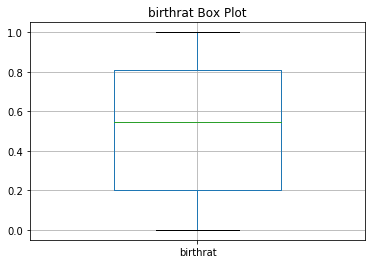

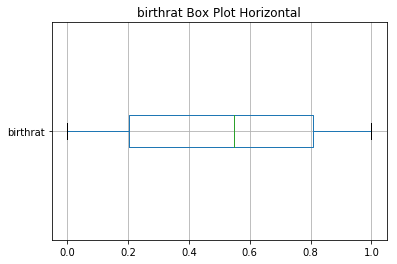

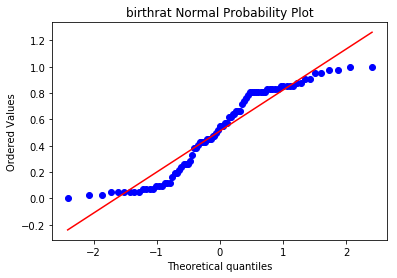



 Univariate Profiling: Examining the Shape of Distribution for hospbed


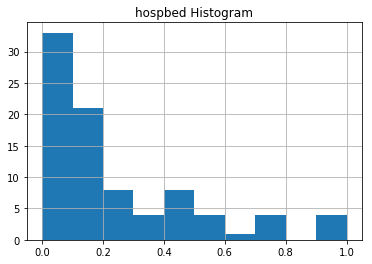

Mean (solid line): 0.24352243969397488
Median(dotted line): 0.14208796864483944


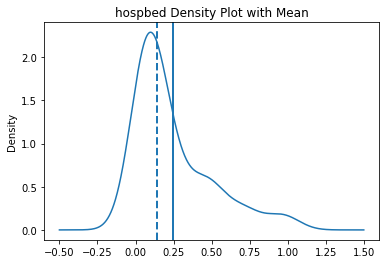

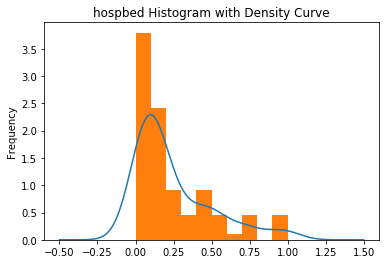

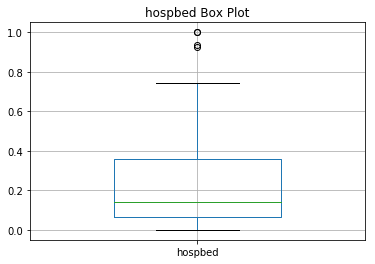

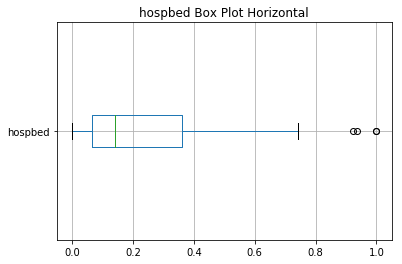

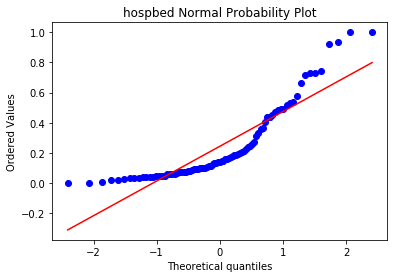



 Univariate Profiling: Examining the Shape of Distribution for docs


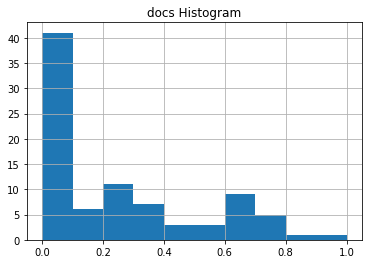

Mean (solid line): 0.24847103828478193
Median(dotted line): 0.1350669932918708


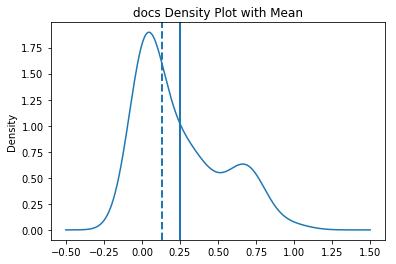

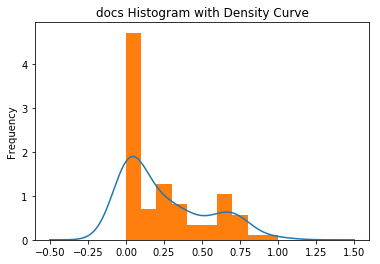

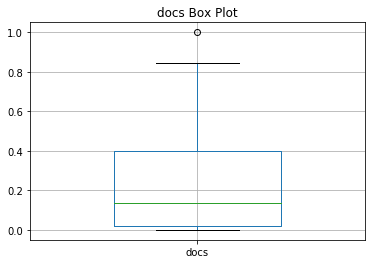

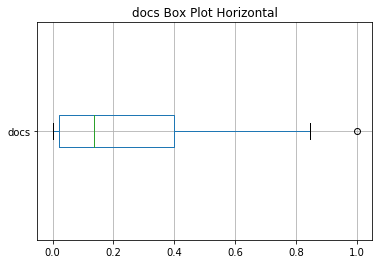

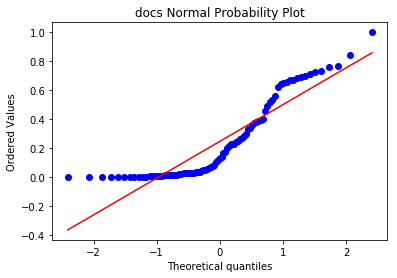



 Univariate Profiling: Examining the Shape of Distribution for radio


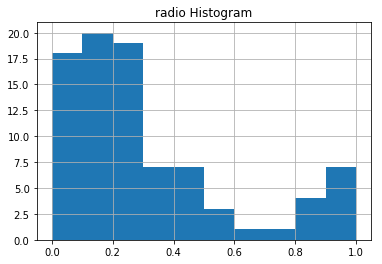

Mean (solid line): 0.3159388820712183
Median(dotted line): 0.22037652270210412


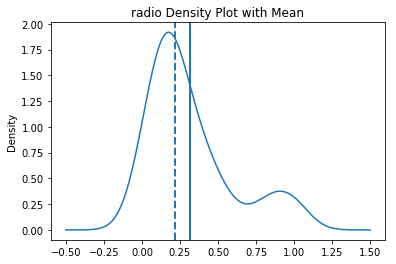

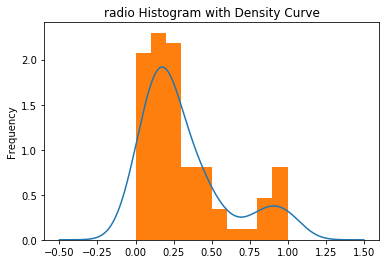

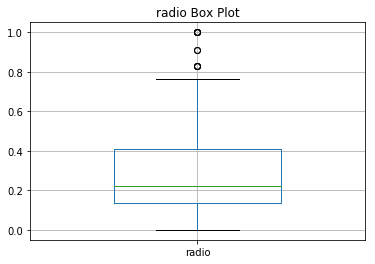

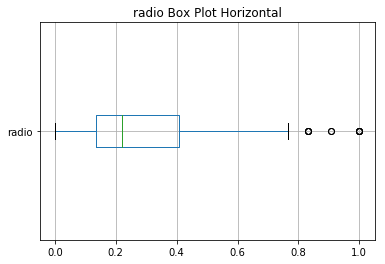

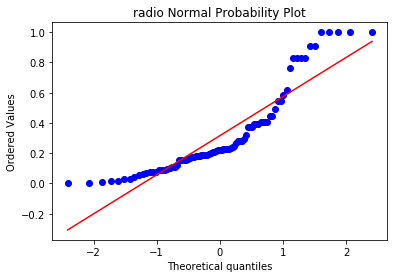



 Univariate Profiling: Examining the Shape of Distribution for phone


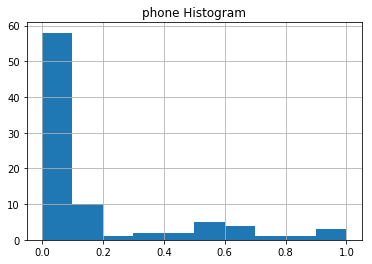

Mean (solid line): 0.16273077474122083
Median(dotted line): 0.03444867949351471


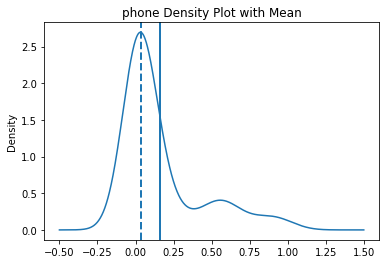

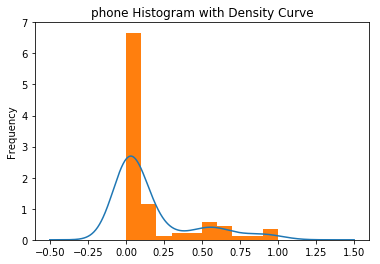

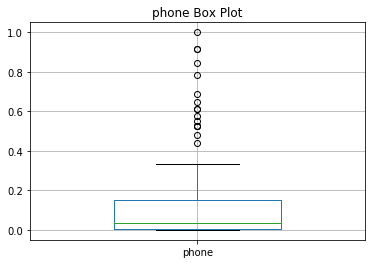

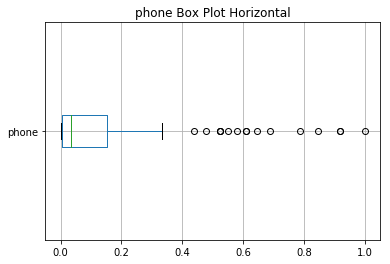

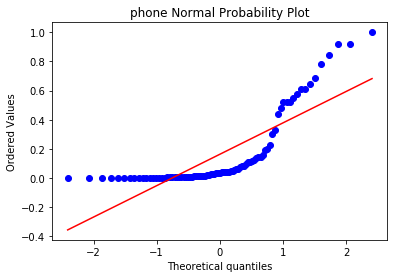

In [123]:
def display_distribution(i, df):
    print('\n\n Univariate Profiling: Examining the Shape of Distribution for {}'.format(i))
    # Histogram
    df.hist(column=i)
    plt.title("{} Histogram".format(i))
    plt.show()
    
    ax = df[i].plot(kind='density')
    mean_val = df[i].mean()
    median_val = df[i].median()
    print("Mean (solid line): {}\nMedian(dotted line): {}".format(mean_val, median_val))
    plt.axvline(mean_val, linestyle='solid', linewidth=2)
    plt.axvline(median_val, linestyle='dashed', linewidth=2)
    plt.title("{} Density Plot with Mean".format(i))
    plt.show()
    
    df[i].plot.kde()
    df[i].plot.hist(normed=True)
    plt.title("{} Histogram with Density Curve".format(i))
    plt.show()
    
    
    # Box Plot
    df.boxplot(column=i, widths=0.5)
    plt.title("{} Box Plot".format(i))
    plt.show()
    
    df.boxplot(column=i, vert=False) 
    plt.title("{} Box Plot Horizontal".format(i))
    plt.show()
    
    # Normal Probability Plot (QQ Plot)
    stats.probplot(df[i], dist="norm", plot=pylab)
    plt.title("{} Normal Probability Plot".format(i))
    plt.show()
    
    
for var in features:
    display_distribution(var, df)

### Testing homosedaciticity

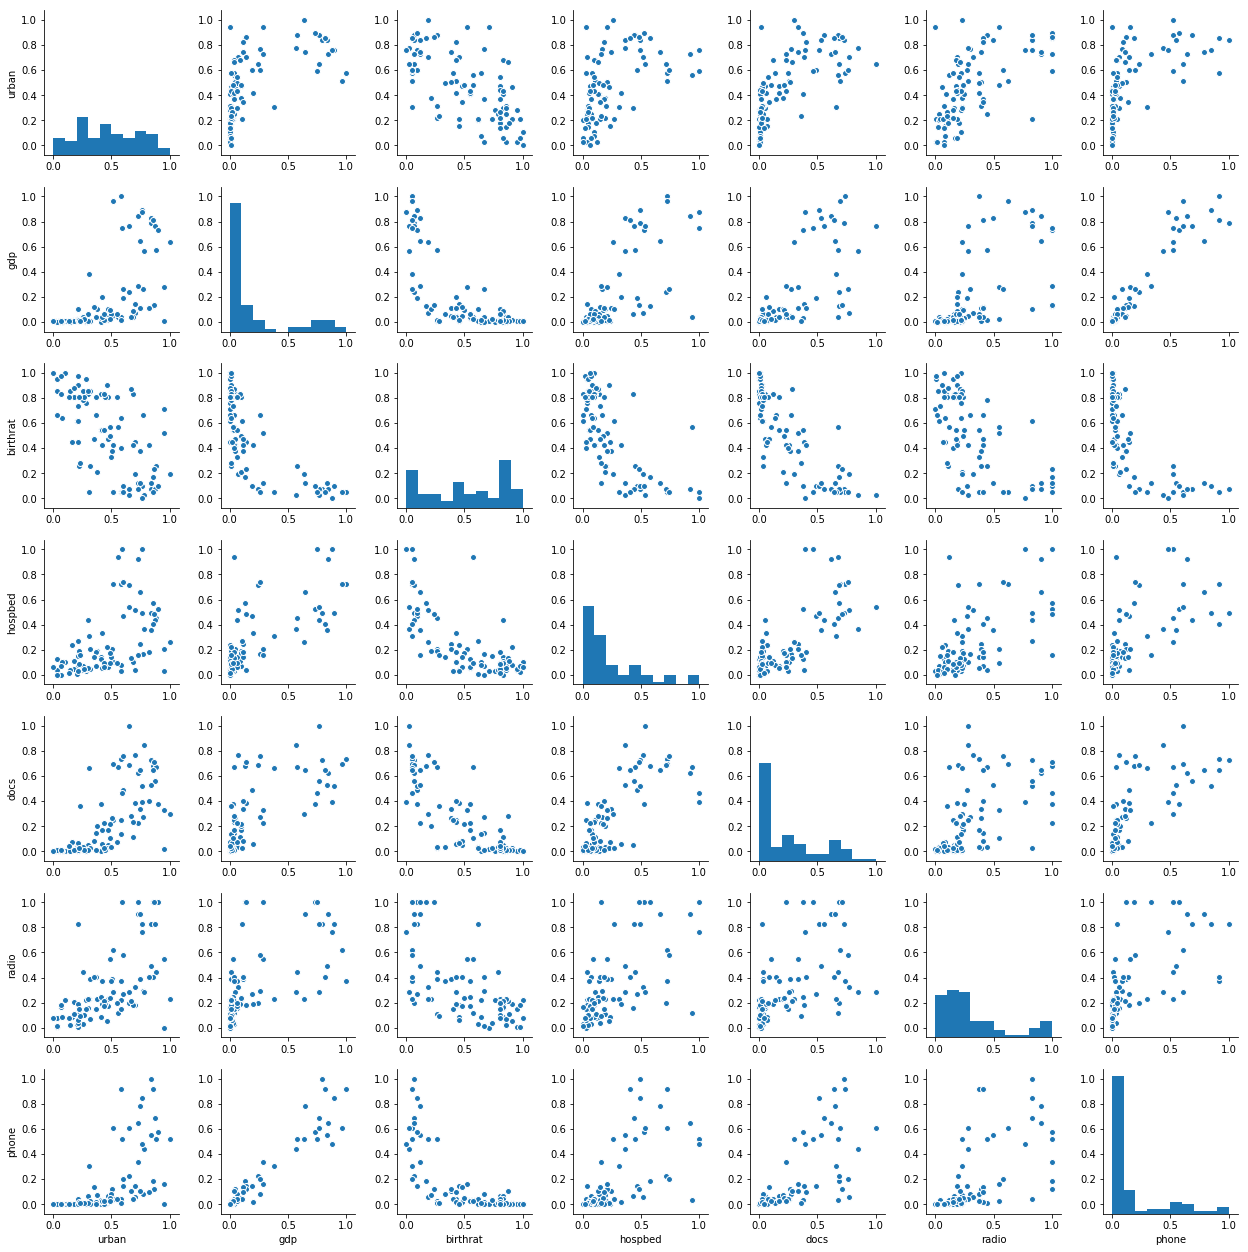

In [124]:
# Print scatter plots for each metric variable to determine homoscedasity
sb.pairplot(df[[*features]])
plt.show()

### Bivariate outlier detection

In [125]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

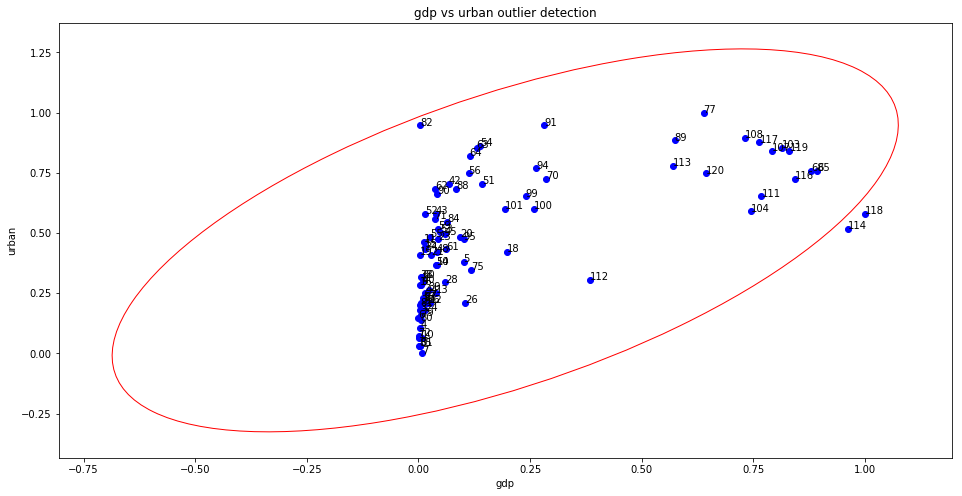

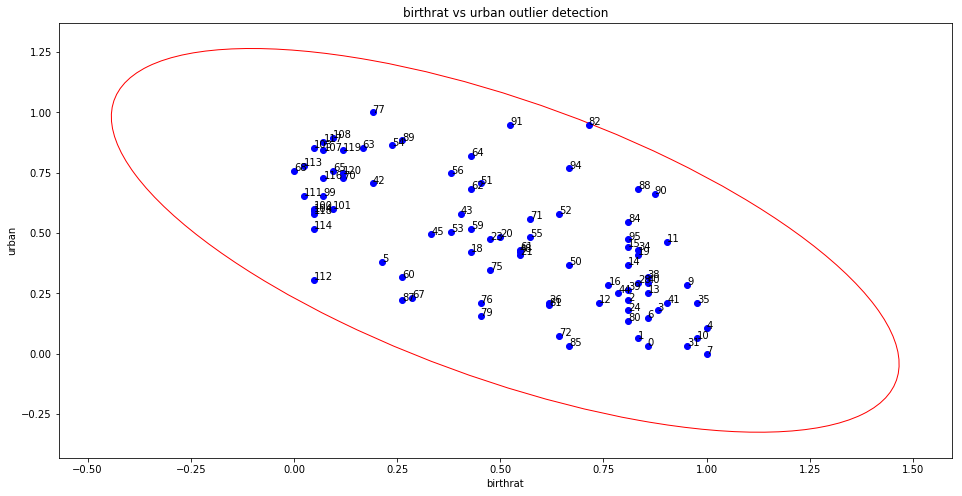

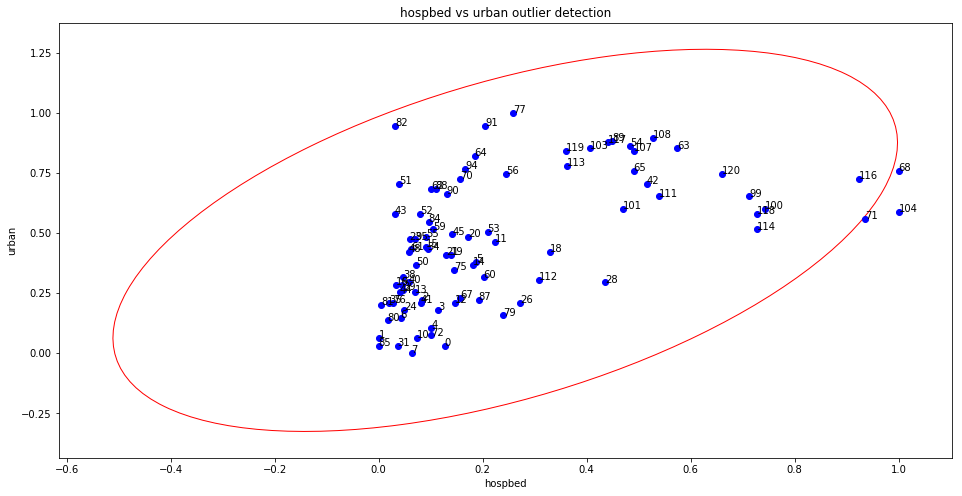

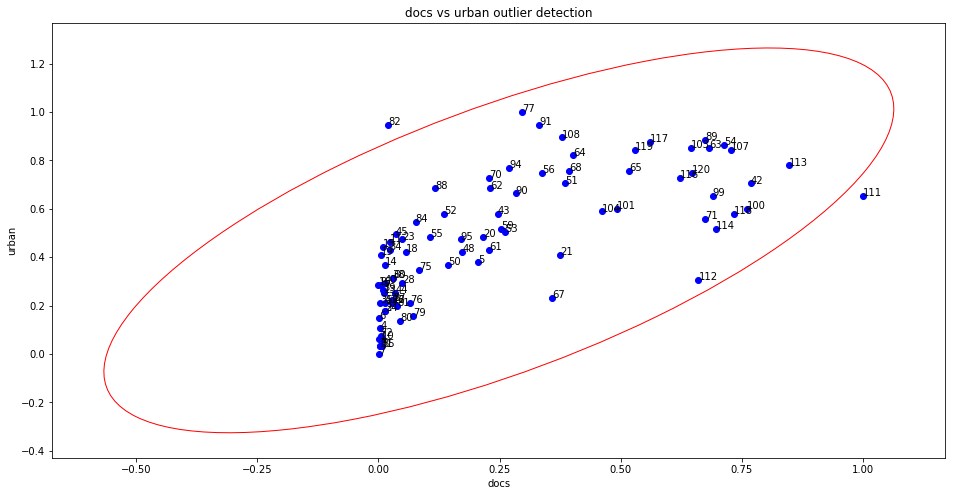

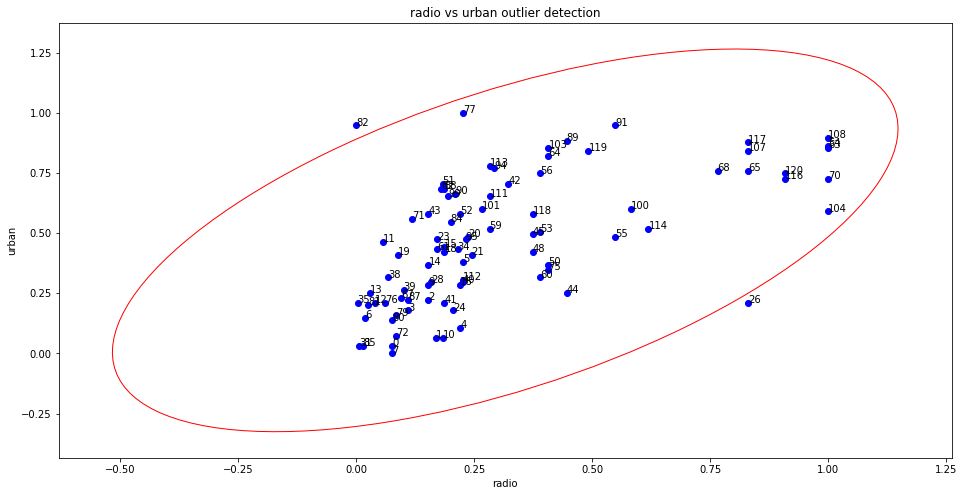

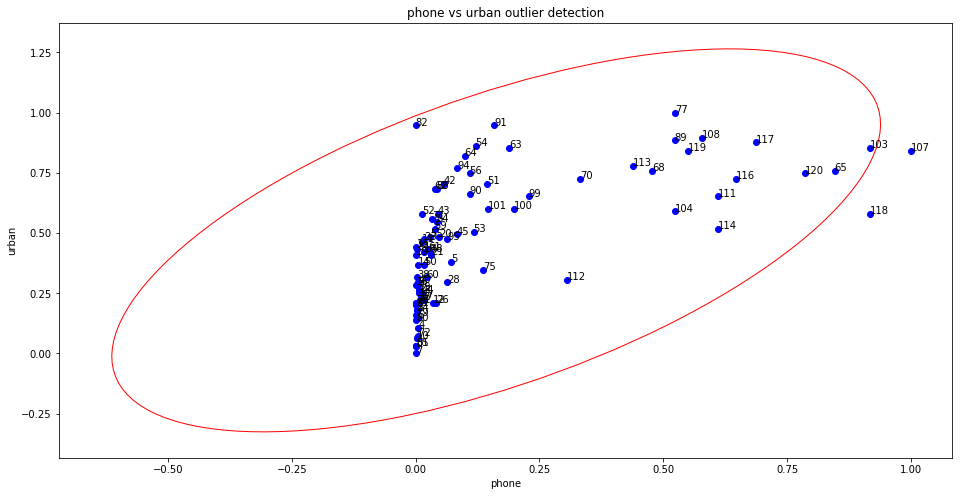

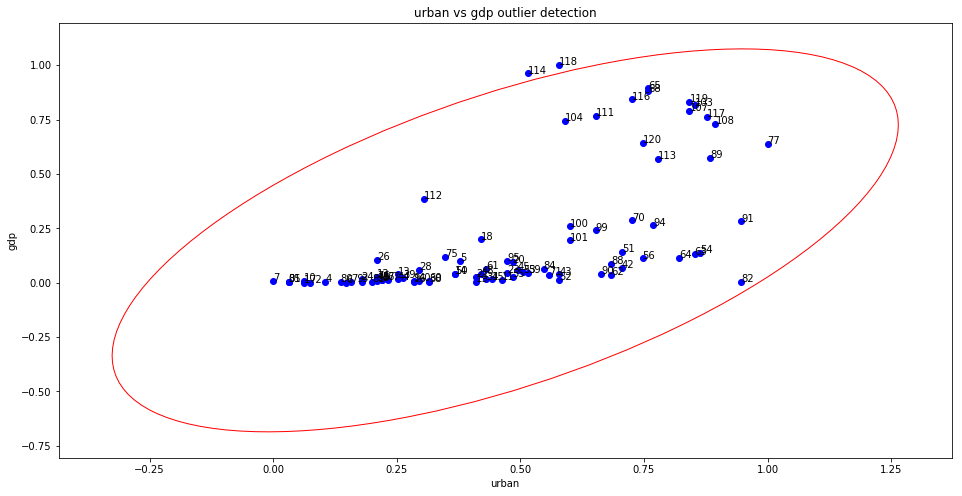

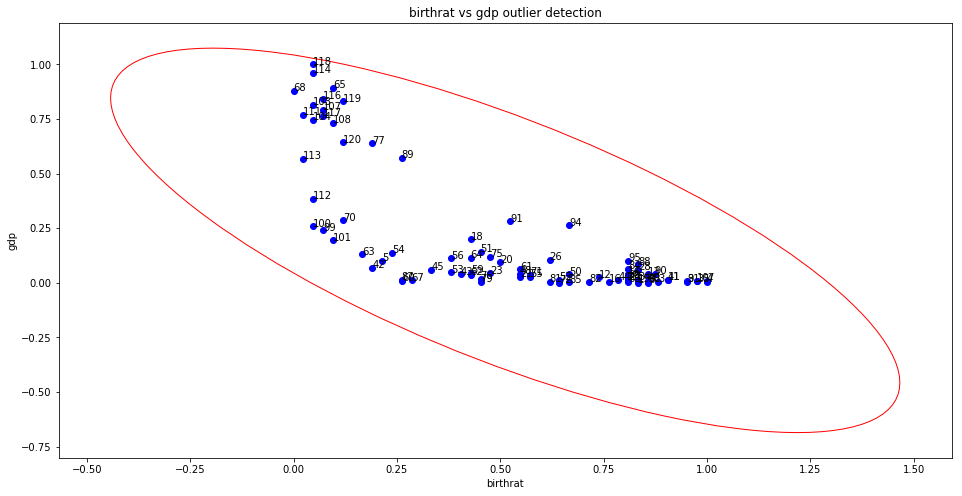

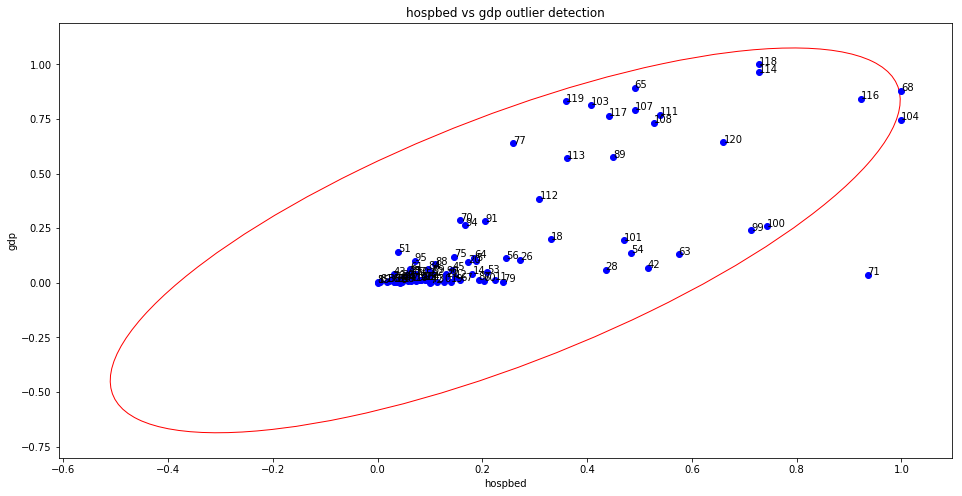

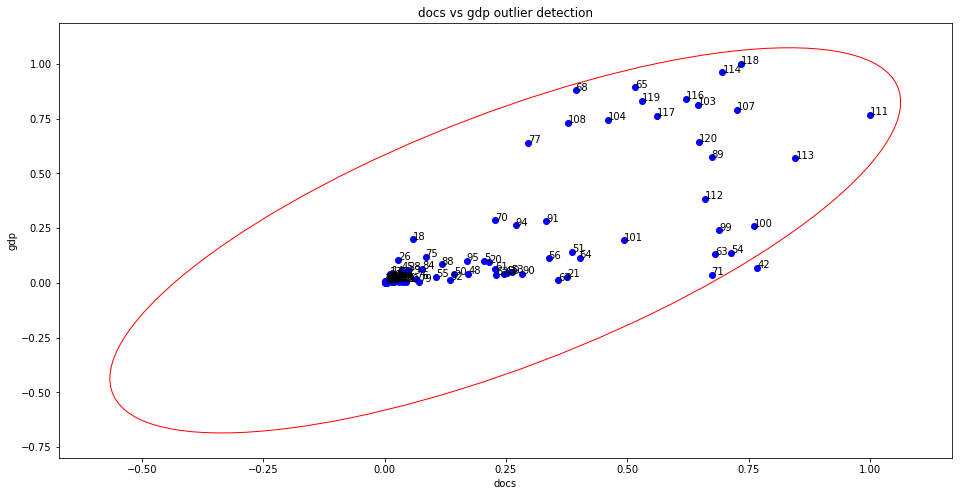

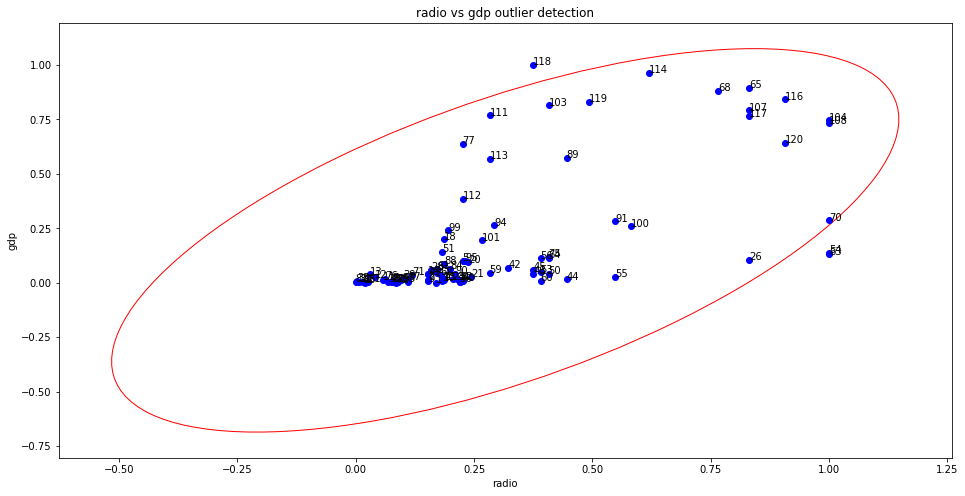

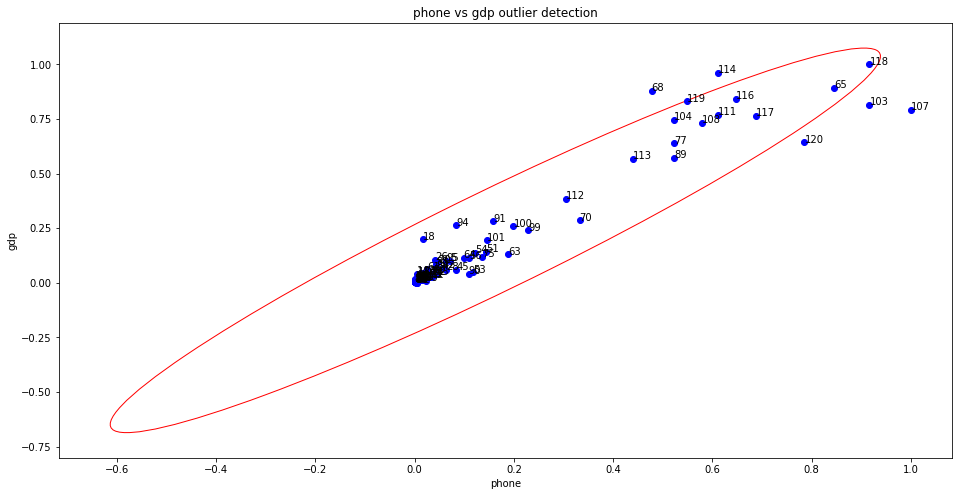

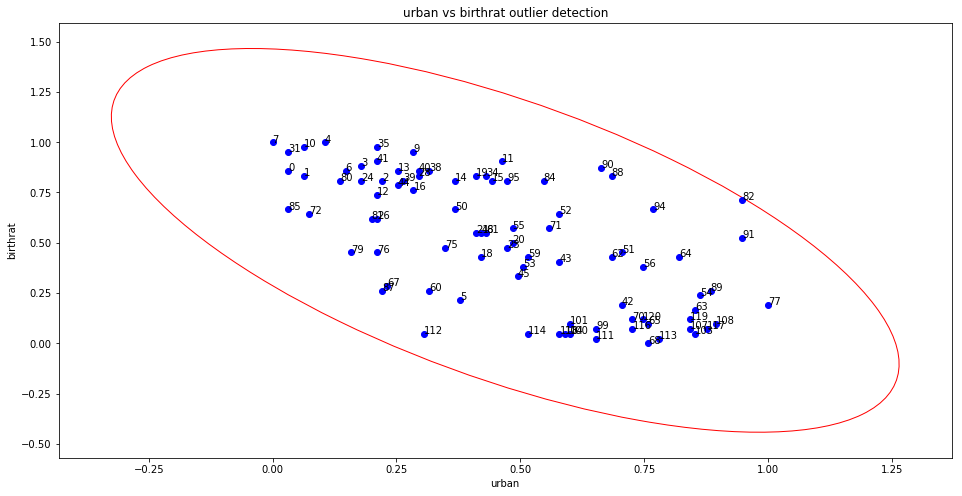

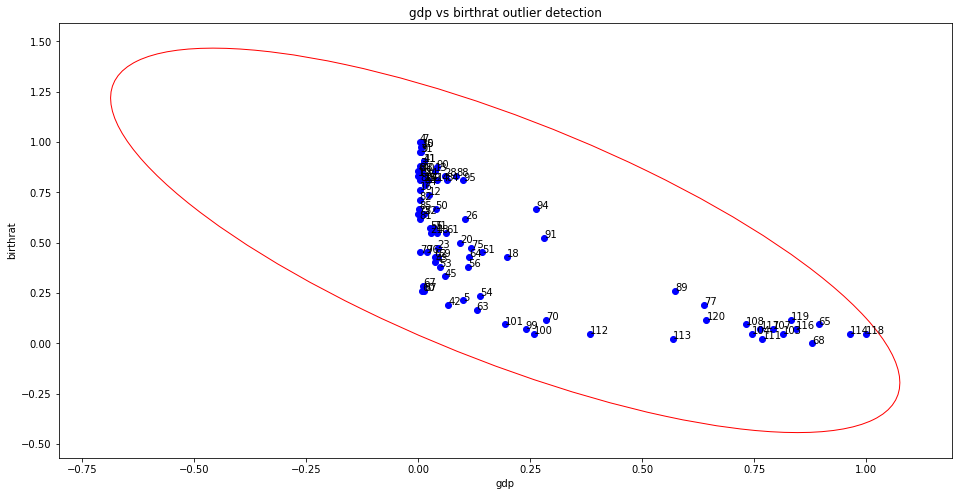

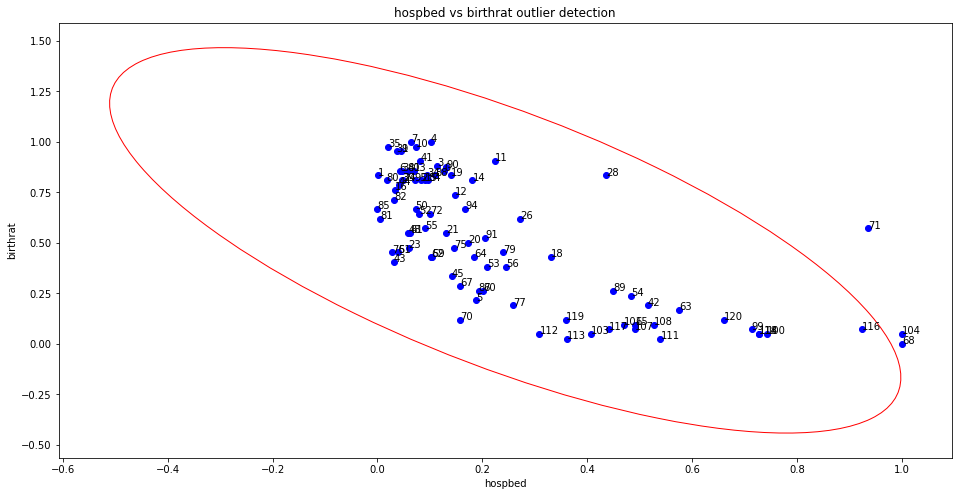

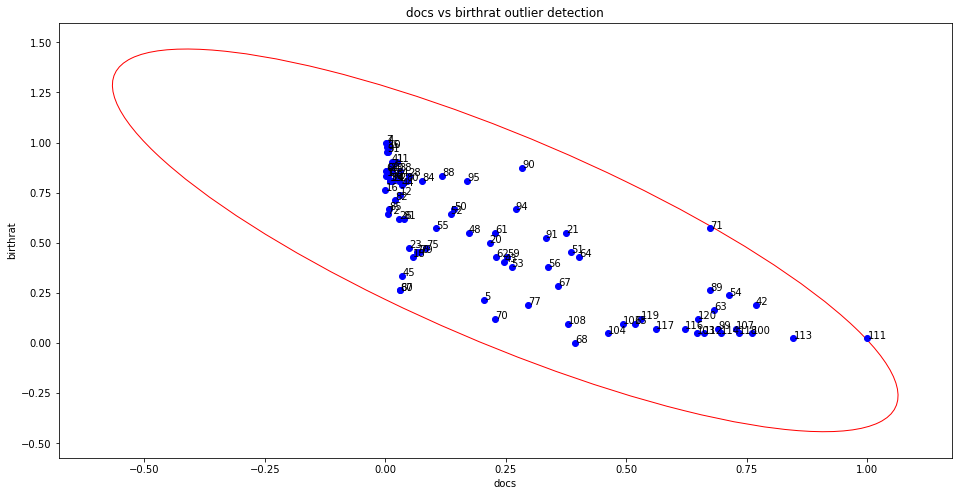

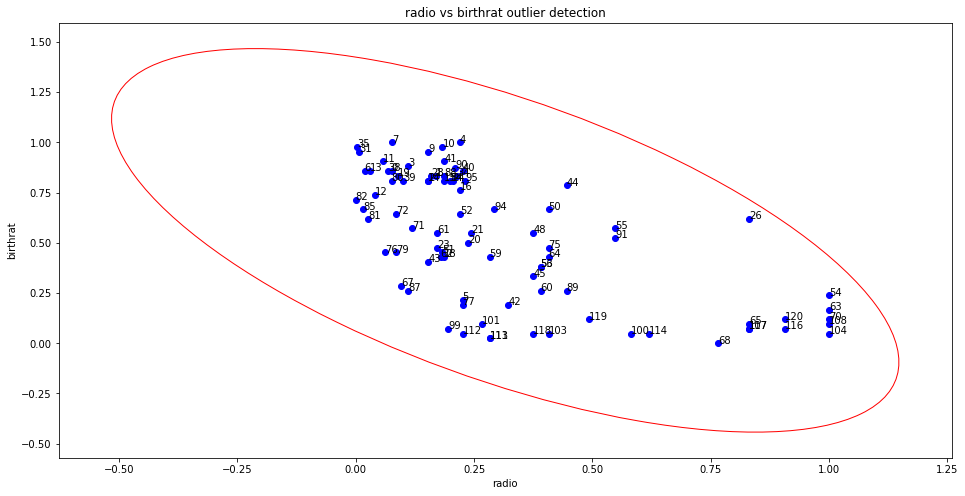

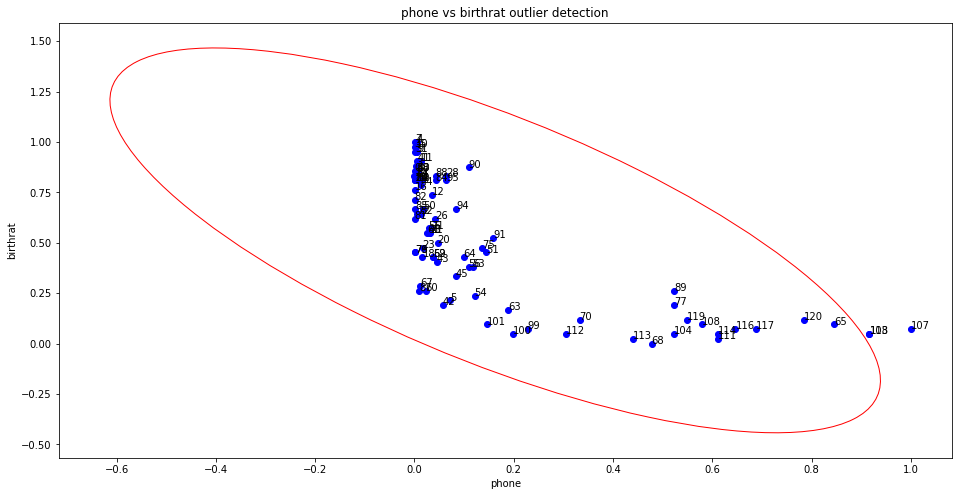

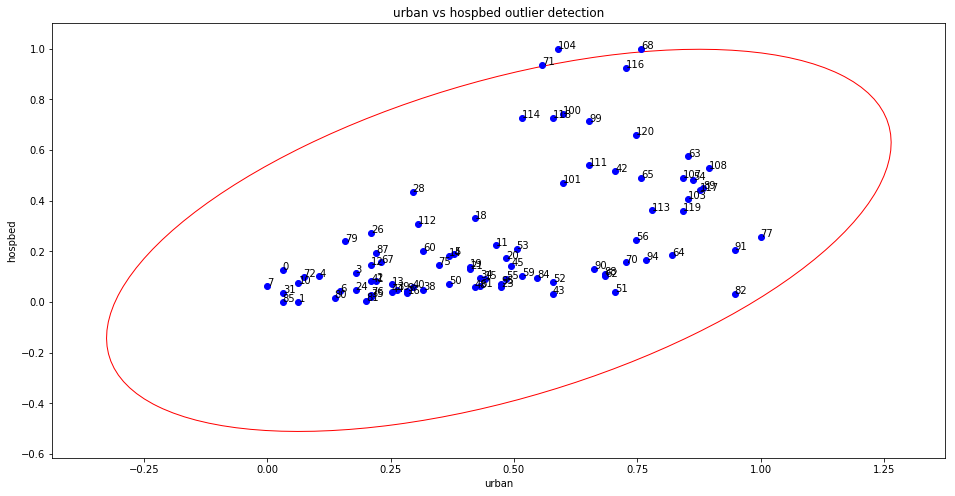

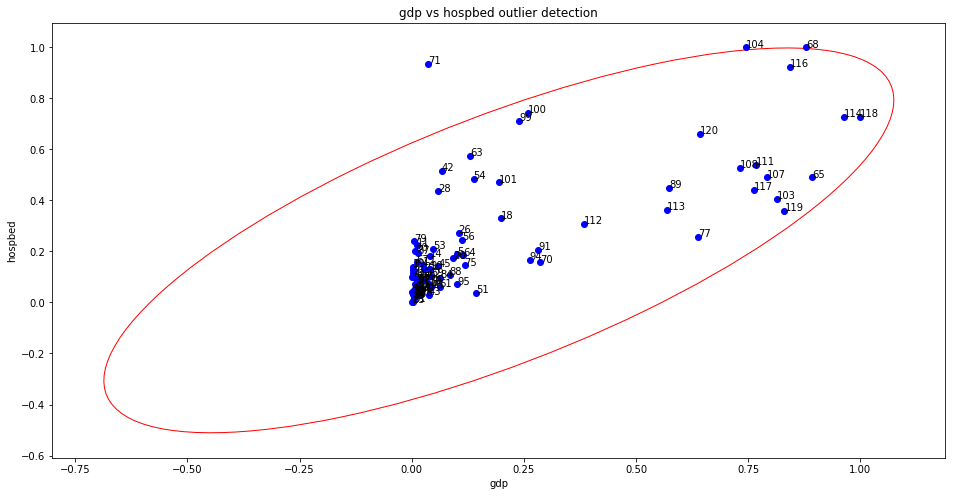

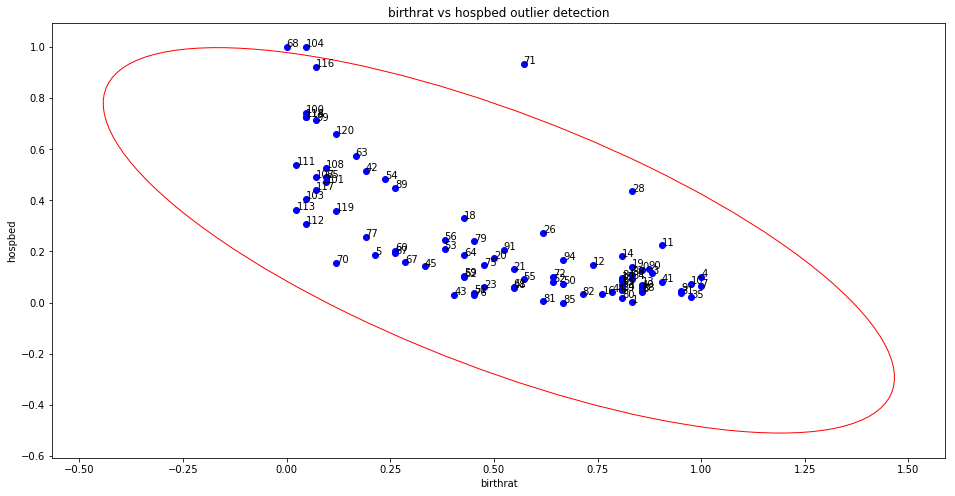

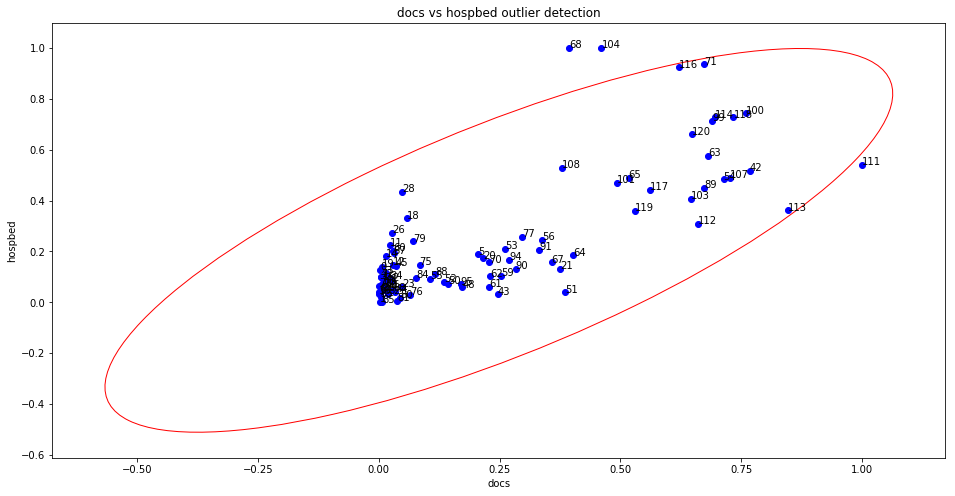

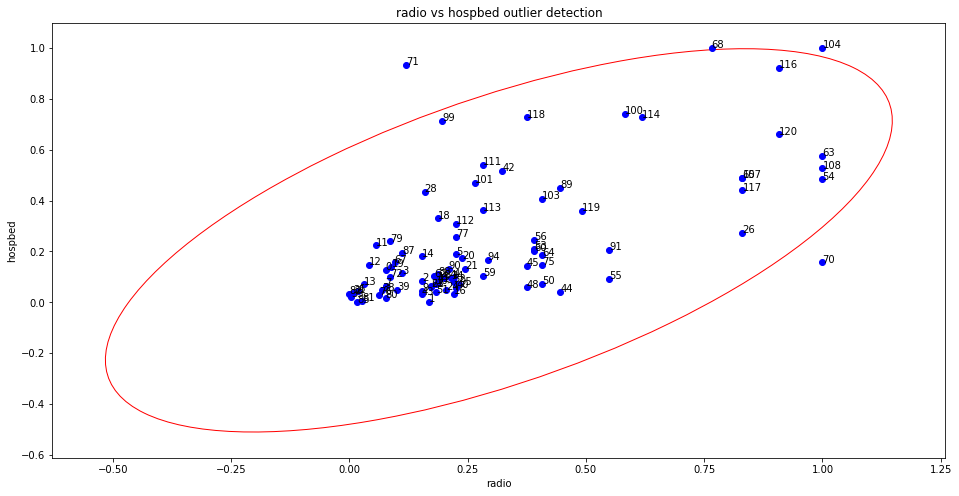

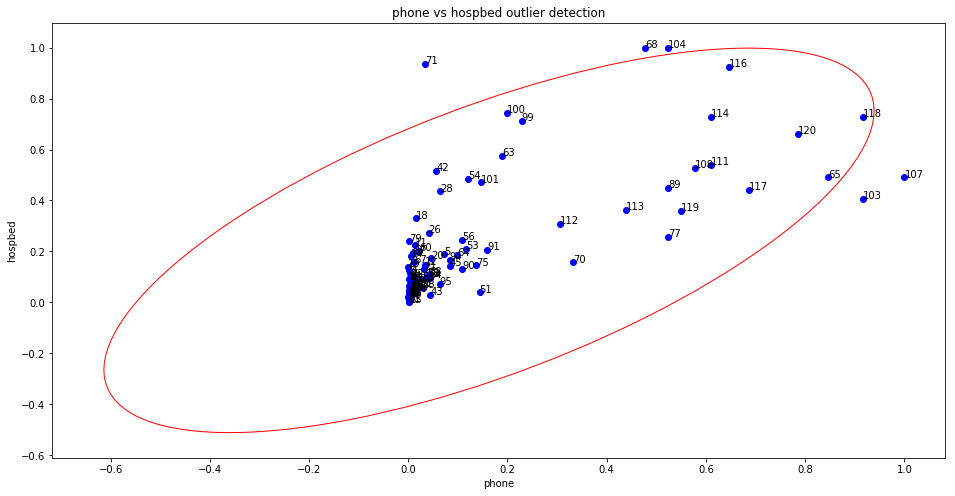

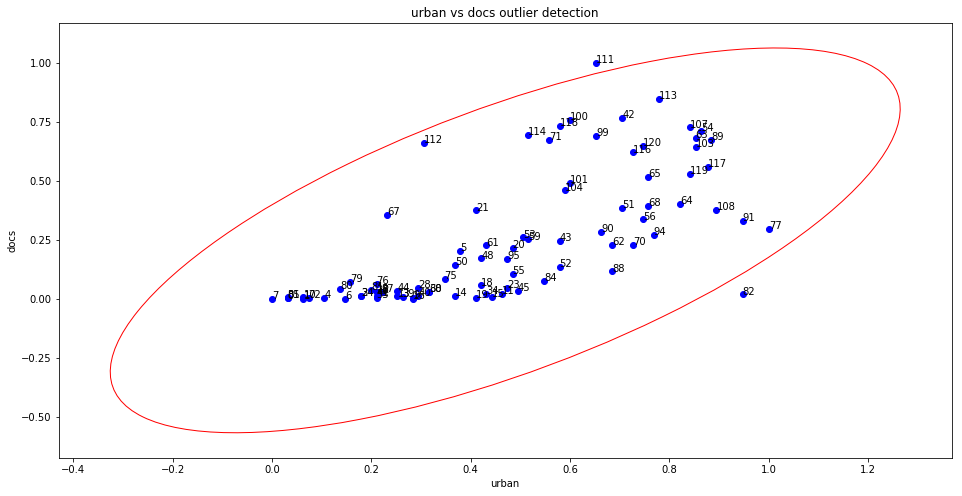

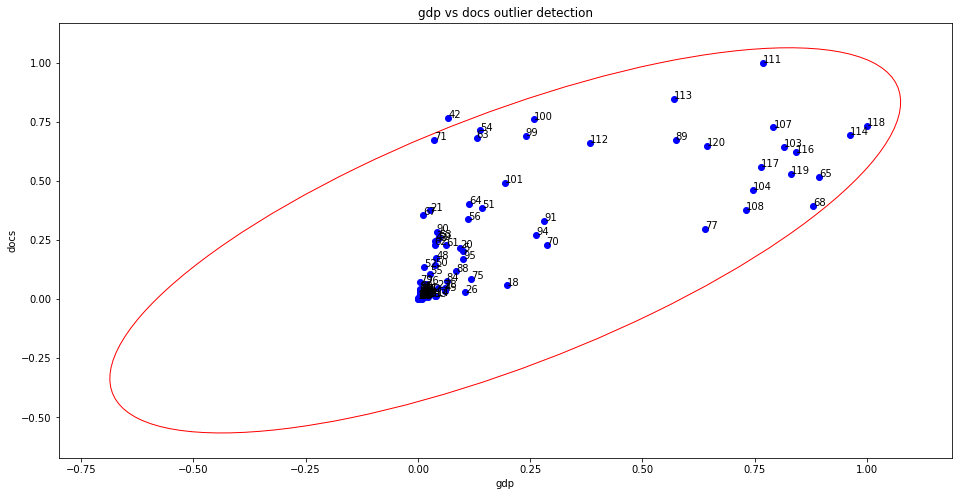

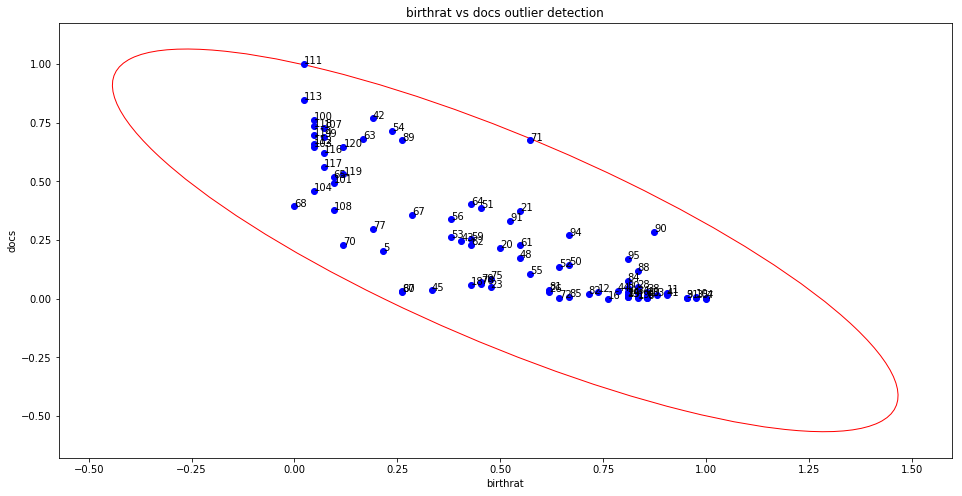

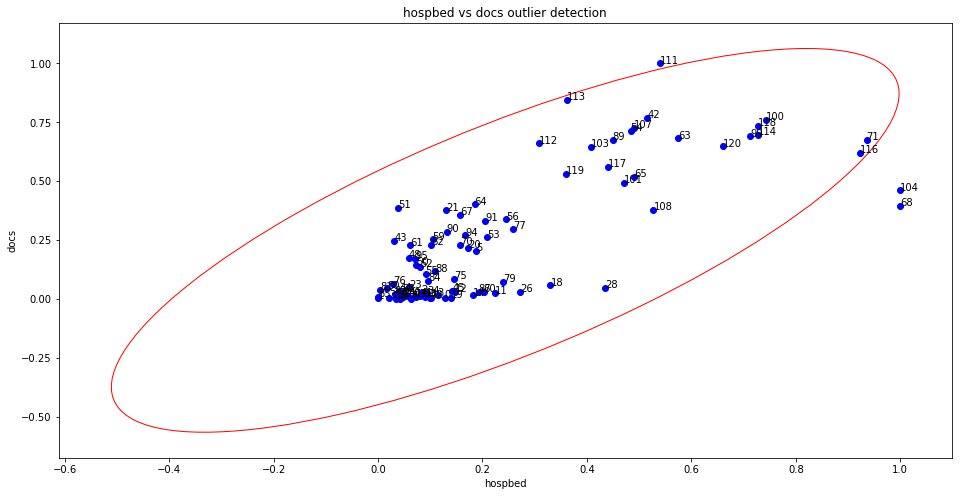

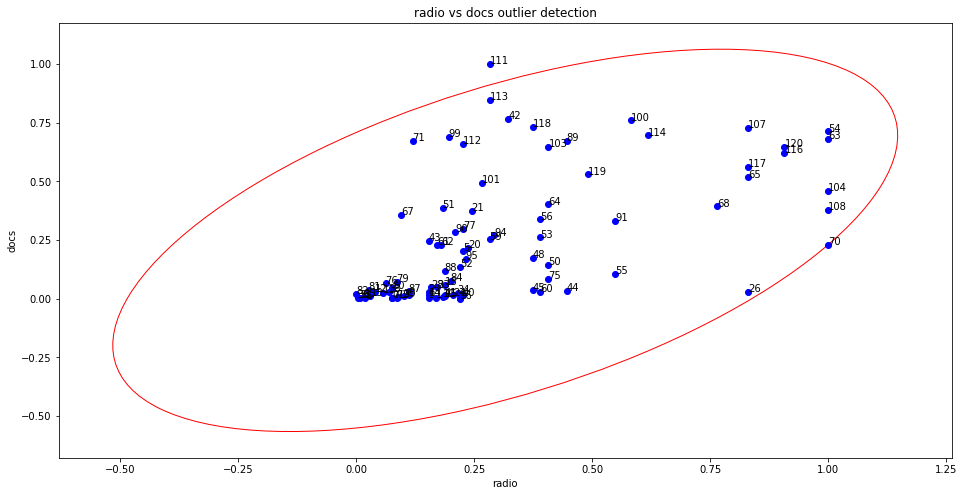

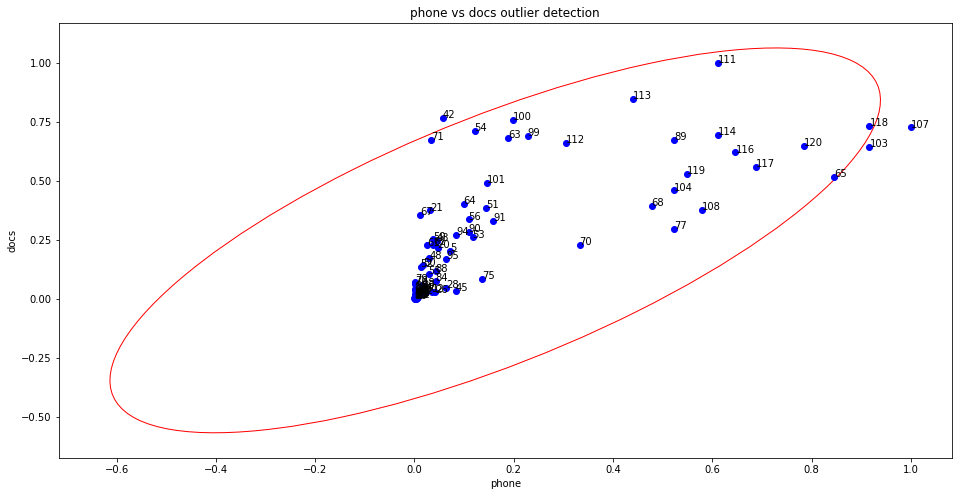

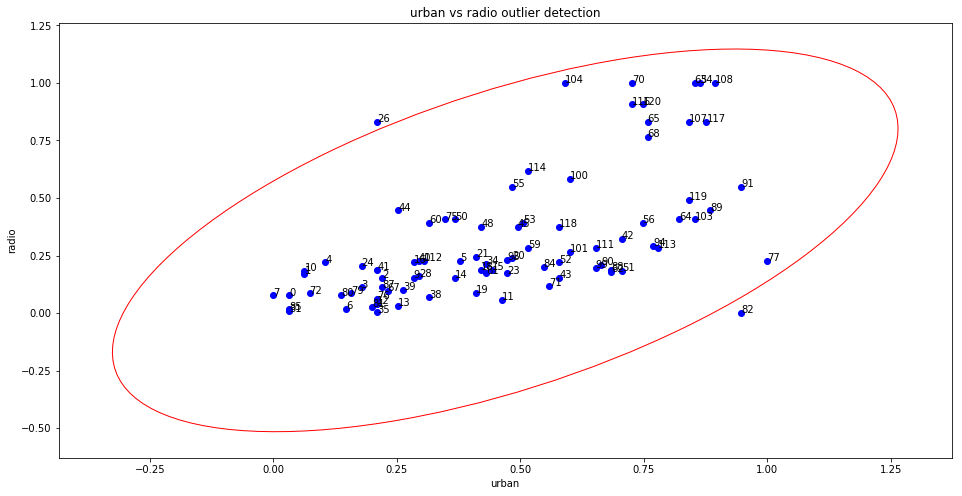

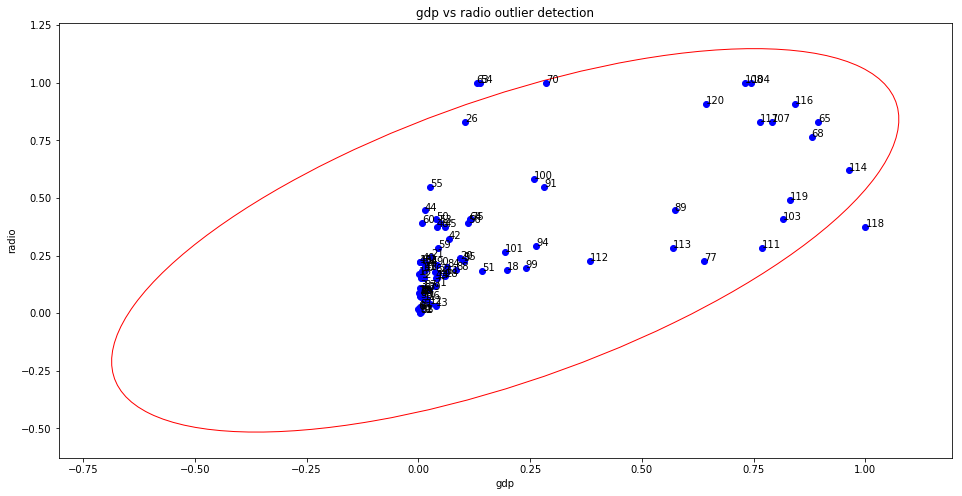

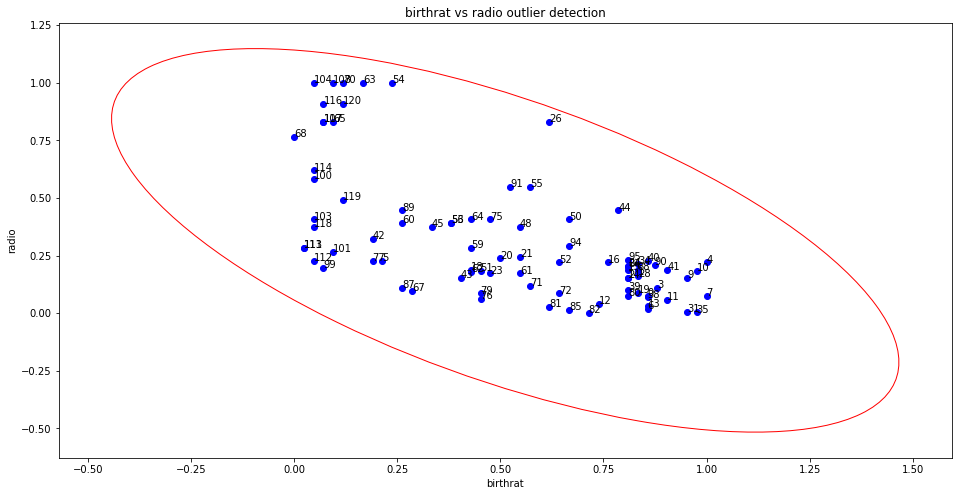

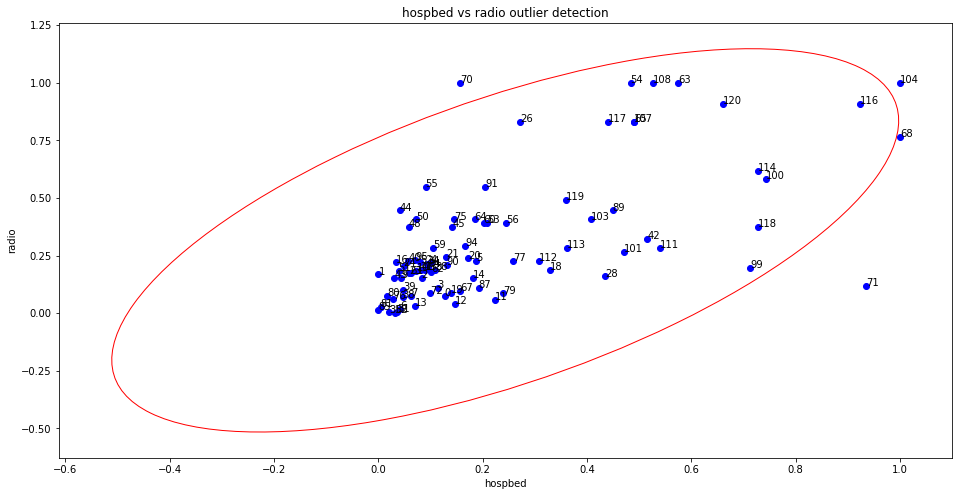

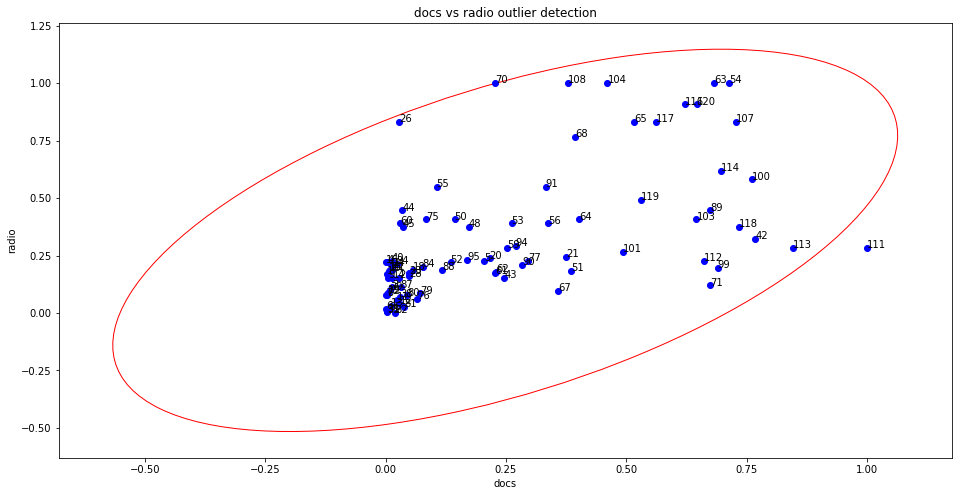

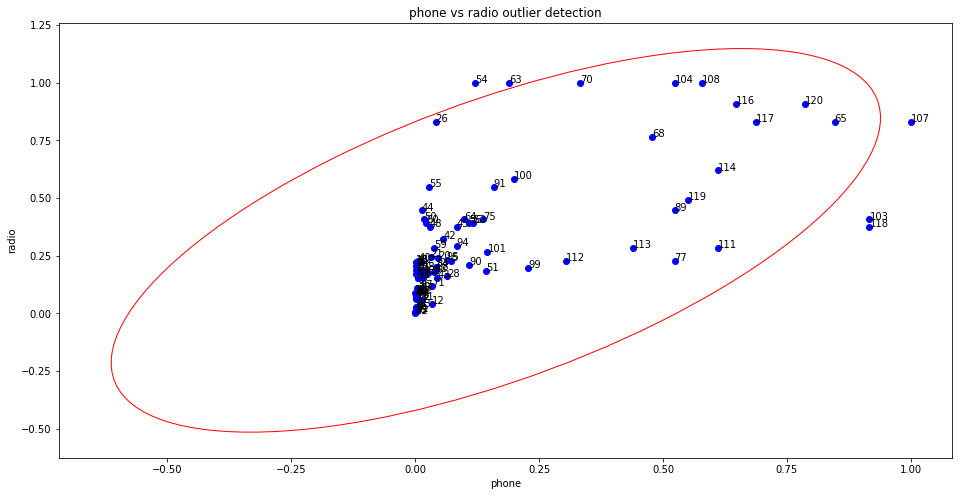

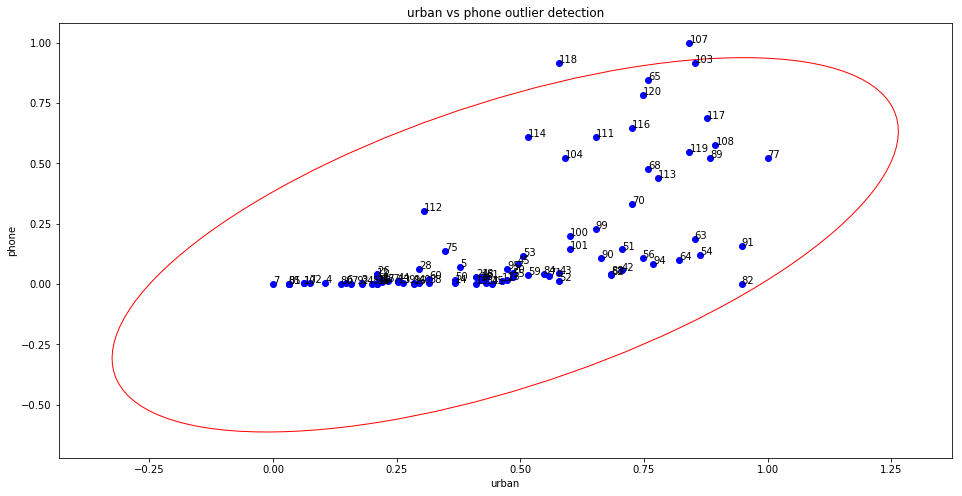

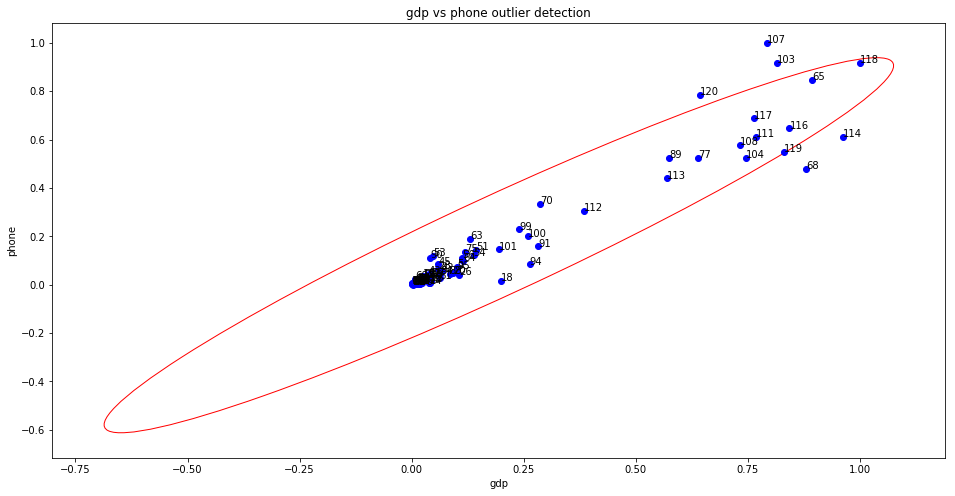

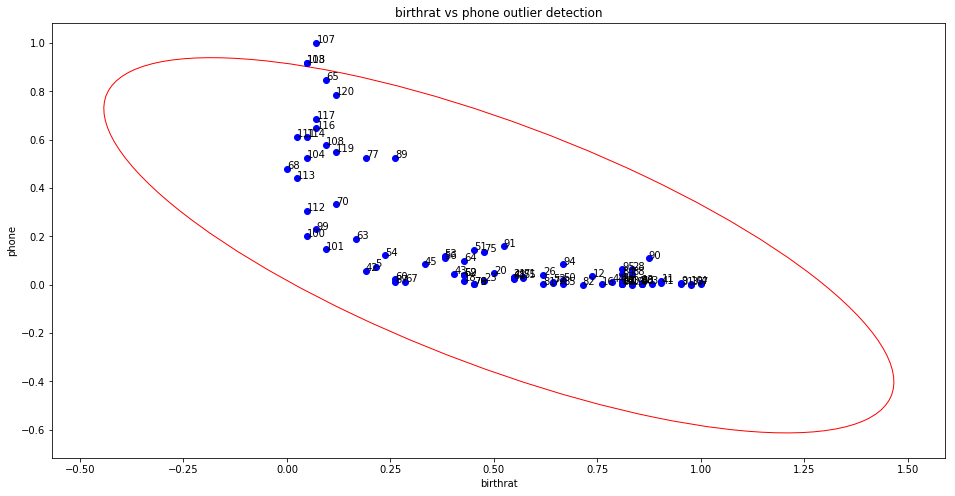

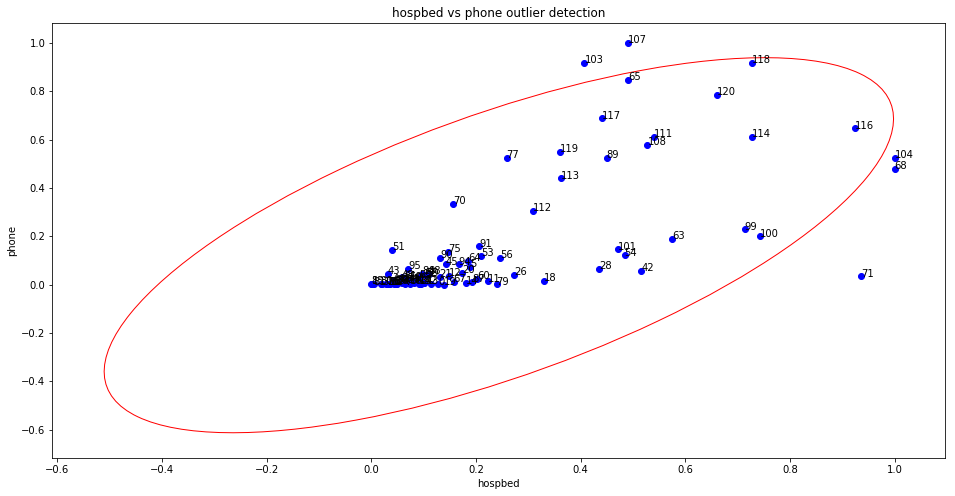

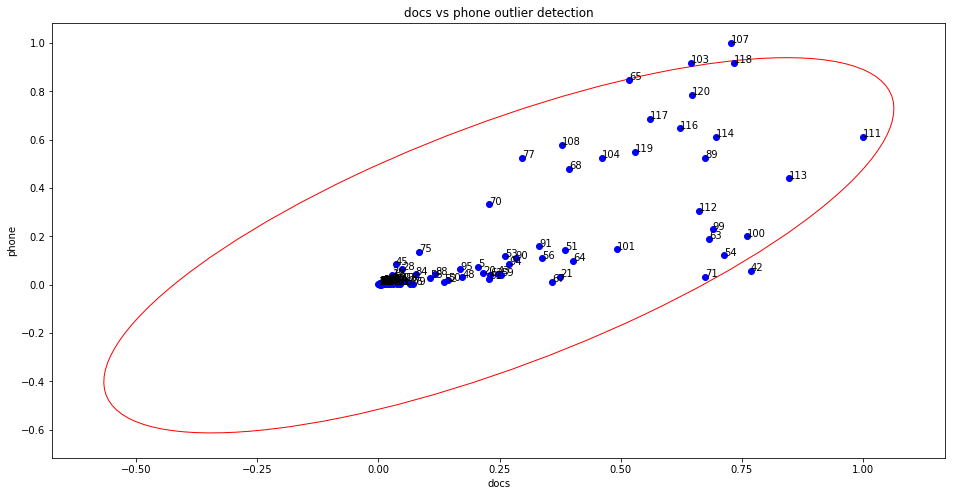

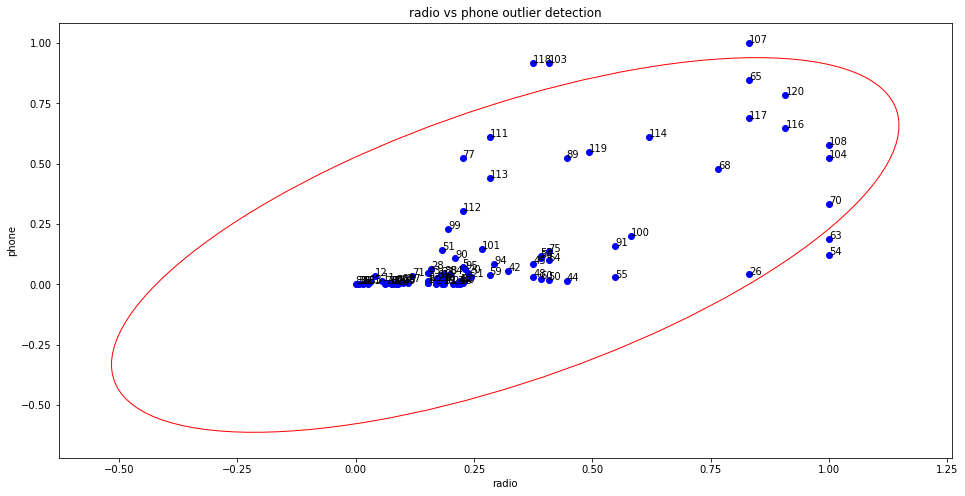

In [135]:
for i in features:
    for j in features:
        if i != j:
            x = df[j]
            y = df[i]
            fig, ax = plt.subplots(figsize=(16,8))
            confidence_ellipse(x, y, ax, edgecolor='red')
            # Plot a transparent 3 standard deviation covariance ellipse
            ax.scatter(x, y, s=0.5, c='black')
            ax.set_xlabel(j)
            ax.set_ylabel(i)
            ax.set_title('{} vs {} outlier detection'.format(j, i))

            for p in range(len(x)):
                pointRefNumber = df.index[p]
                xPoint =  df[j].iloc[p]
                yPoint =  df[i].iloc[p]
                ax.plot(xPoint, yPoint, 'bo')
                ax.annotate(pointRefNumber, (xPoint, yPoint), color='black')
            plt.show()

In [136]:
# Stepwise model: eliminated 4 features
current_features = list(features)
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('hospbed')
current_features.remove('radio')
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print('Step Model')
print(current_features)
print('Mean Absolute Error:', metrics.mean_absolute_error(ty_test, ty_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(ty_test, ty_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ty_test, ty_pred)))
r_sq = tmodel.score(tx_train, ty_train)
print('coefficient of determination:', r_sq)
print('intercept:', tmodel.intercept_)
print('slope:', tmodel.coef_)

Step Model
['urban', 'birthrat', 'docs']
Mean Absolute Error: 0.14175015867419472
Mean Squared Error: 0.032240944175489304
Root Mean Squared Error: 0.17955763469006075
coefficient of determination: 0.799494158615678
intercept: [0.78267382]
slope: [[ 0.16326006 -0.52773093  0.13035906]]


In [137]:
# Part a model
features = 'urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone'
x = df[[*features]]
y = df[['lifeexpf']]
# Train test split for evaluation later
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Model A')
print(features)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r_sq = model.score(x_train, y_train)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

Model A
('urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone')
Mean Absolute Error: 0.14759055747867517
Mean Squared Error: 0.03334085172348057
Root Mean Squared Error: 0.18259477463356003
coefficient of determination: 0.8061073217967796
intercept: [0.75005196]
slope: [[ 0.14057073  0.0329062  -0.49883329 -0.06706283  0.1785829   0.12528468
  -0.07868383]]



 Univariate Normality test for urban


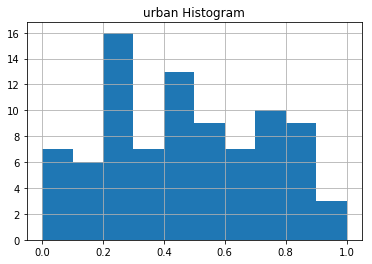

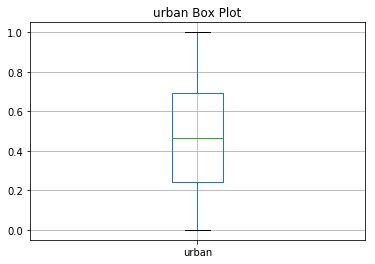

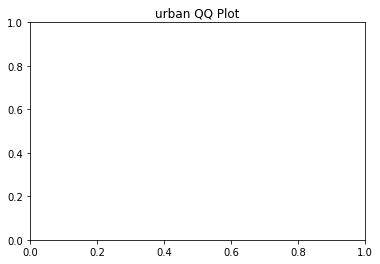

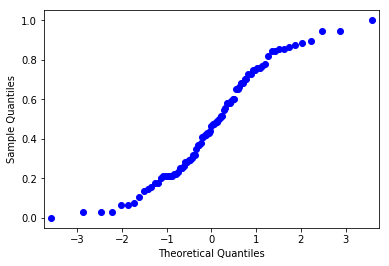


 Test of Normality for urban
K-S Test: p-value = 9.86301e-21
We reject the null hypothesis that urban is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 0.0213185
We reject the null hypothesis that urban is normally distributed. The distribution is not normal

 Test Shape of Distribution for urban
Skewness Z-test p-value = 0.000572894
We reject the null hypothesis for urban
Kurtoses Z-test p-value = 0.00012691
The null hypothesis can be rejected for urban

 Univariate Normality test for gdp


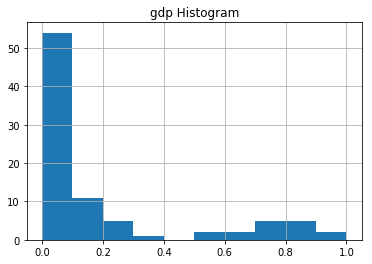

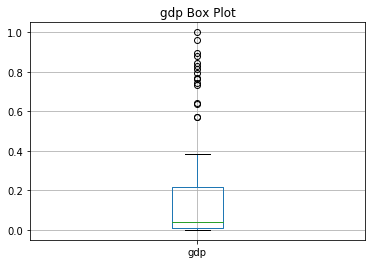

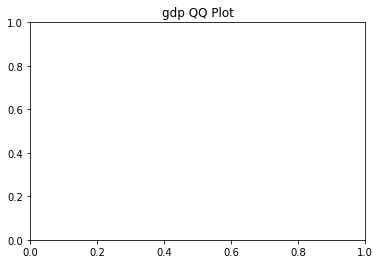

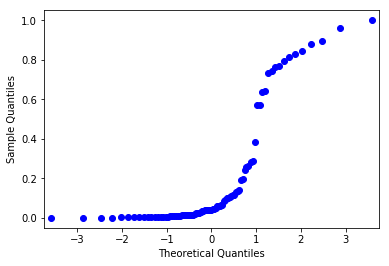


 Test of Normality for gdp
K-S Test: p-value = 1.22799e-20
We reject the null hypothesis that gdp is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 1.19081e-12
We reject the null hypothesis that gdp is normally distributed. The distribution is not normal

 Test Shape of Distribution for gdp
Skewness Z-test p-value = 2.21942e-06
We reject the null hypothesis for gdp
Kurtoses Z-test p-value = 0.103603
The null hypothesis cannot be rejected for gdp

 Univariate Normality test for birthrat


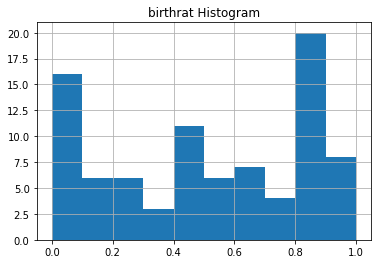

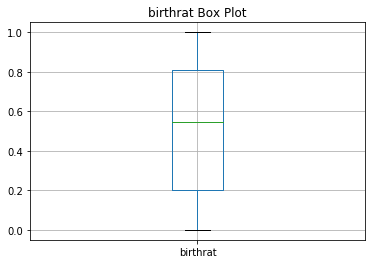

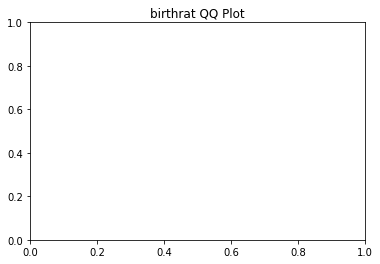

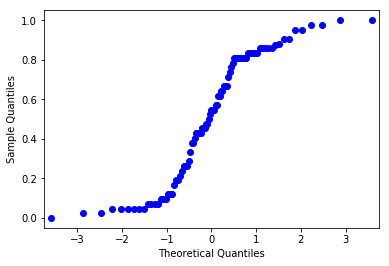


 Test of Normality for birthrat
K-S Test: p-value = 1.22799e-20
We reject the null hypothesis that birthrat is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 2.6067e-05
We reject the null hypothesis that birthrat is normally distributed. The distribution is not normal

 Test Shape of Distribution for birthrat
Skewness Z-test p-value = 1.96859e-15
We reject the null hypothesis for birthrat
Kurtoses Z-test p-value = 2.36998e-16
The null hypothesis can be rejected for birthrat

 Univariate Normality test for hospbed


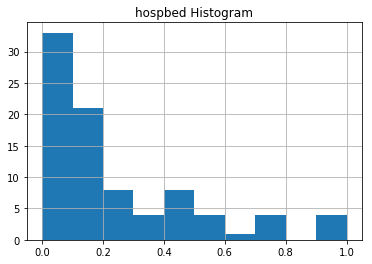

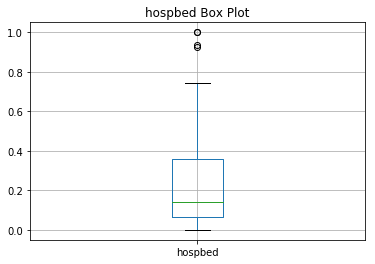

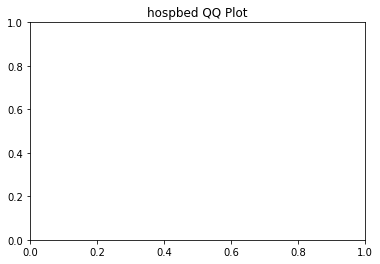

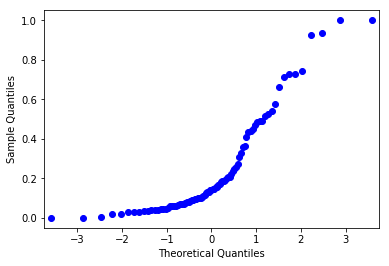


 Test of Normality for hospbed
K-S Test: p-value = 1.22799e-20
We reject the null hypothesis that hospbed is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 2.52973e-09
We reject the null hypothesis that hospbed is normally distributed. The distribution is not normal

 Test Shape of Distribution for hospbed
Skewness Z-test p-value = 2.3175e-06
We reject the null hypothesis for hospbed
Kurtoses Z-test p-value = 0.0332723
The null hypothesis can be rejected for hospbed

 Univariate Normality test for docs


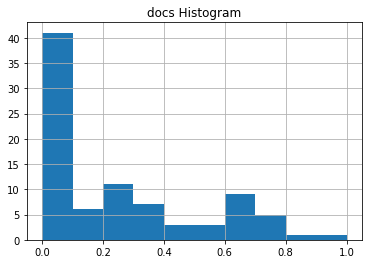

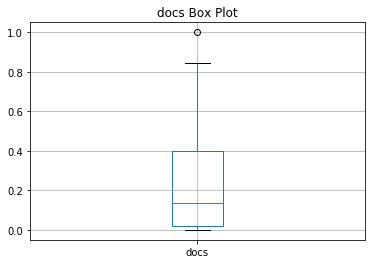

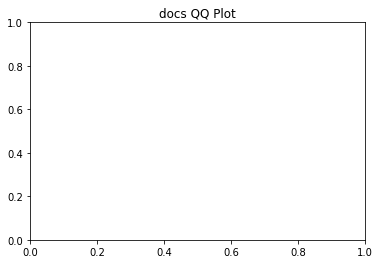

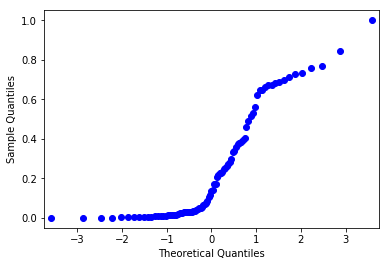


 Test of Normality for docs
K-S Test: p-value = 1.22799e-20
We reject the null hypothesis that docs is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 1.57174e-08
We reject the null hypothesis that docs is normally distributed. The distribution is not normal

 Test Shape of Distribution for docs
Skewness Z-test p-value = 0.00351035
We reject the null hypothesis for docs
Kurtoses Z-test p-value = 0.336852
The null hypothesis cannot be rejected for docs

 Univariate Normality test for radio


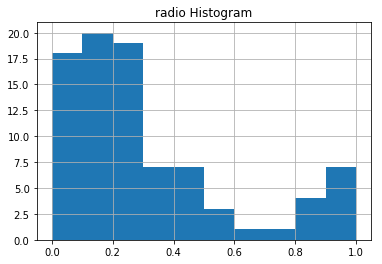

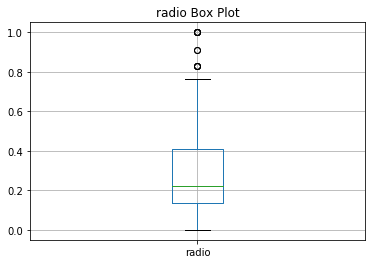

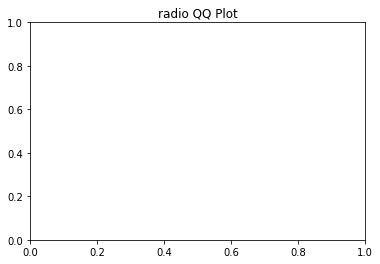

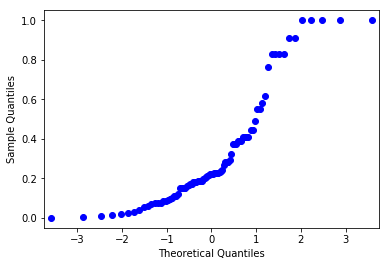


 Test of Normality for radio
K-S Test: p-value = 1.22799e-20
We reject the null hypothesis that radio is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 1.84221e-08
We reject the null hypothesis that radio is normally distributed. The distribution is not normal

 Test Shape of Distribution for radio
Skewness Z-test p-value = 6.02762e-05
We reject the null hypothesis for radio
Kurtoses Z-test p-value = 0.188038
The null hypothesis cannot be rejected for radio

 Univariate Normality test for phone


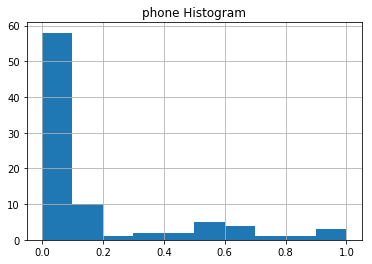

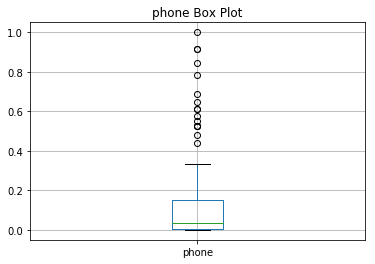

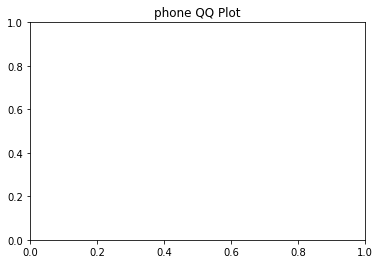

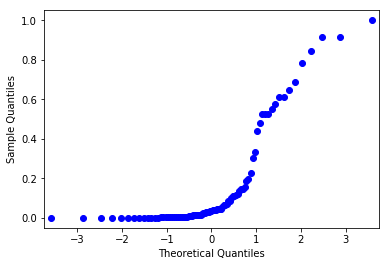


 Test of Normality for phone
K-S Test: p-value = 1.22799e-20
We reject the null hypothesis that phone is normally distributed. The distribution is not normal
Shapiro Wick Test: p-value = 9.96436e-13
We reject the null hypothesis that phone is normally distributed. The distribution is not normal

 Test Shape of Distribution for phone
Skewness Z-test p-value = 2.86299e-08
We reject the null hypothesis for phone
Kurtoses Z-test p-value = 0.00792413
The null hypothesis can be rejected for phone


In [138]:
# Testing Normality
alpha = 0.05
levene = pd.DataFrame(columns=['x_var', 'y_var', 'p_val', 'hypothesis'])
transforms_to_test = []

for i in features:
    print('\n Univariate Normality test for {}'.format(i))
    # Histogram
    temp_hist = df.hist(column=i)
    plt.title("{} Histogram".format(i))
    plt.show()
    # Box Plot
    age_box = df.boxplot(column=i)
    plt.title("{} Box Plot".format(i))
    plt.show()
    # Normality (QQ Plot)
    #stats.probplot(df[i], dist="norm", plot=pylab)
    plt.title("{} QQ Plot".format(i))
    plt.show()
    fig = sm.qqplot(df[i], stats.t, distargs=(4,))
    plt.show()
    
    print('\n Test of Normality for {}'.format(i))
    # K-S Test
    k2, ksp = stats.kstest(df[i], 'norm', N=350)
    print("K-S Test: p-value = {:g}".format(ksp))
    if ksp < alpha:  # null hypothesis: x comes from a normal distribution
        hypothesis = "We reject the null hypothesis that {0} is normally distributed. The distribution is not normal".format(i)
        if i not in transforms_to_test:
            transforms_to_test.append(i)
    else:
        hypothesis = "We fail to reject the null hypothesis that {0} is not normally distributed. The distribution is normal".format(i)
    print(hypothesis)
    # Shapiro Wick Test
    k2, swp = stats.shapiro(df[i])
    print("Shapiro Wick Test: p-value = {:g}".format(swp))
    if swp < alpha:  # null hypothesis: x comes from a normal distribution
        hypothesis = "We reject the null hypothesis that {0} is normally distributed. The distribution is not normal".format(i)
        if i not in transforms_to_test:
            transforms_to_test.append(i)
    else:
        hypothesis = "We fail to reject the null hypothesis that {0} is not normally distributed. The distribution is normal".format(i)
    print(hypothesis)
    
    print('\n Test Shape of Distribution for {}'.format(i))
    k2, np = stats.normaltest(df[i])
    print("Skewness Z-test p-value = {:g}".format(np))
    if np < alpha:  # null hypothesis: x comes from a normal distribution
        print("We reject the null hypothesis for {}".format(i))
    else:
        print("The null hypothesis cannot be rejected for {}".format(i))
    
    k2, p = stats.kurtosistest(df[i])
    print("Kurtoses Z-test p-value = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected for {}".format(i))
    else:
        print("The null hypothesis cannot be rejected for {}".format(i))
        


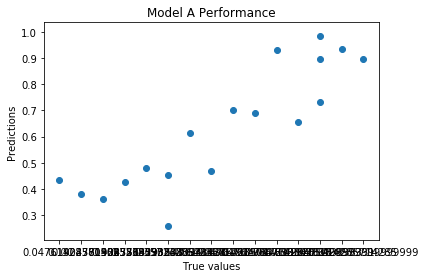

In [139]:
plt.scatter(y_test,y_pred)
plt.title('Model A Performance')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

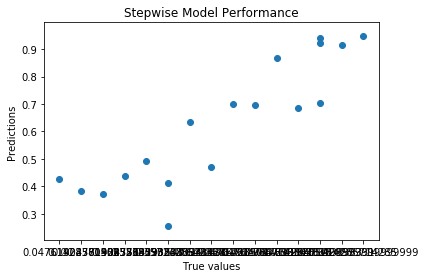

In [140]:
plt.scatter(ty_test,ty_pred)
plt.title('Stepwise Model Performance')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()

In [141]:
import statistics
statistics.mean(model.coef_[0])

-0.023890777165180448

In [142]:
statistics.mean(tmodel.coef_[0])


-0.07803727013695941

In [143]:
def multicollinearity_check(X, thresh=5.0):
    data_type = X.dtypes
    # print(type(data_type))
    int_cols = \
    X.select_dtypes(include=['int', 'int16', 'int32', 'int64', 'float', 'float16', 'float32', 'float64']).shape[1]
    total_cols = X.shape[1]
    try:
        if int_cols != total_cols:
            raise Exception('All the columns should be integer or float, for multicollinearity test.')
        else:
            variables = list(range(X.shape[1]))
            dropped = True
            print('''\n\nThe VIF calculator will now iterate through the features and calculate their respective values.
            It shall continue dropping the highest VIF features until all the features have VIF less than the threshold of 5.\n\n''')
            while dropped:
                dropped = False
                vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in variables]
                print('\n\nvif is: ', vif)
                maxloc = vif.index(max(vif))
                if max(vif) > thresh:
                    print('dropping \'' + X.iloc[:, variables].columns[maxloc] + '\' at index: ' + str(maxloc))
                    # del variables[maxloc]
                    X.drop(X.columns[variables[maxloc]], 1, inplace=True)
                    variables = list(range(X.shape[1]))
                    dropped = True

            print('\n\nRemaining variables:\n')
            print(X.columns[variables])
            # return X.iloc[:,variables]
            return X
    except Exception as e:
        print('Error caught: ', e)
        
multicollinearity_check(x)



The VIF calculator will now iterate through the features and calculate their respective values.
            It shall continue dropping the highest VIF features until all the features have VIF less than the threshold of 5.


Error caught:  name 'variance_inflation_factor' is not defined


In [144]:
multicollinearity_check(df[current_features])



The VIF calculator will now iterate through the features and calculate their respective values.
            It shall continue dropping the highest VIF features until all the features have VIF less than the threshold of 5.


Error caught:  name 'variance_inflation_factor' is not defined


In [56]:
sex_variance_results = stats.levene(df['charges'][df['sex'] == 0], 
                                    df['charges'][df['sex'] == 1], center= 'median')

smoker_variance_results = stats.levene(df['charges'][df['smoker'] == 0],
                                       df['charges'][df['smoker'] == 1], center= 'median')

region_variance_results = stats.levene(df['charges'][df['region_northeast'] == 1],
                                       df['charges'][df['region_northwest'] == 1],
                                       df['charges'][df['region_southeast'] == 1],
                                       df['charges'][df['region_southwest'] == 1], center= 'median')

print(f"Sex Variance: {sex_variance_results}", "\n",
      f"Smoker Variance: {smoker_variance_results}", "\n",
      f"Region Variance: {region_variance_results}", "\n")

KeyError: 'charges'

## G. Repeat or Male Life Expectancy

In [145]:
# Part a model
features = 'urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone'
x = df[[*features]]
y = df[['lifeexpm']]
# Train test split for evaluation later
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Model A')
print(features)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r_sq = model.score(x_train, y_train)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

Model A
('urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone')
Mean Absolute Error: 0.14022602906451934
Mean Squared Error: 0.03069100755812243


AttributeError: 'numpy.float64' object has no attribute 'sqrt'

In [58]:
print(features)
metrics.mean_squared_error(y_test, y_pred)

rfe = RFE(model, 1)
rfe = rfe.fit(x_train, y_train)
rfe.ranking_
feature_elimination = pd.DataFrame(columns=['variable', 'support', 'ranking'])
# print summaries for the selection of attributes
for i in range(len(features)):
    feature_elimination = feature_elimination.append({'variable':features[i], 'support': rfe.support_[i],
                                                      'ranking': rfe.ranking_[i]},ignore_index=True)
feature_elimination

('urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'radio', 'phone')


/Users/req89250/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,variable,support,ranking
0,urban,False,2
1,gdp,False,5
2,birthrat,True,1
3,hospbed,False,6
4,docs,False,3
5,radio,False,7
6,phone,False,4


In [59]:
current_features

['urban', 'birthrat', 'docs']

In [60]:


# Eliminate 1 feature
current_features = list(features)
current_features.remove('radio')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

# Eliminate 2 features
current_features = list(features)
current_features.remove('radio')
current_features.remove('hospbed')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

# Eliminate 3 features
current_features = list(features)
current_features.remove('radio')
current_features.remove('hospbed')
current_features.remove('gdp')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

# Eliminate 4 features
current_features = list(features)
current_features.remove('radio')
current_features.remove('hospbed')
current_features.remove('gdp')
current_features.remove('phone')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

print('intercept:', tmodel.intercept_)
print('slope:', tmodel.coef_)

# Eliiminate 5 features
# Eliminate 4 features
current_features = list(features)
current_features.remove('radio')
current_features.remove('hospbed')
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('docs')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

# Eliminate 6 features
# Eliiminate 5 features
# Eliminate 4 features
current_features = list(features)
current_features.remove('radio')
current_features.remove('hospbed')
current_features.remove('gdp')
current_features.remove('phone')
current_features.remove('docs')
print(current_features)
tx = df[[*current_features]]
ty = df[['lifeexpf']]
tx_train, tx_test, ty_train, ty_test = train_test_split(tx, ty, test_size = 0.2, random_state = 0)
tmodel = LinearRegression().fit(tx_train, ty_train)
ty_pred = tmodel.predict(tx_test)
print(metrics.mean_squared_error(ty_test, ty_pred))

['urban', 'gdp', 'birthrat', 'hospbed', 'docs', 'phone']
0.032291663387201734
['urban', 'gdp', 'birthrat', 'docs', 'phone']
0.03226896164484907
['urban', 'birthrat', 'docs', 'phone']
0.03227872995185459
['urban', 'birthrat', 'docs']
0.032240944175489304
intercept: [0.78267382]
slope: [[ 0.16326006 -0.52773093  0.13035906]]
['urban', 'birthrat']
0.03461848195324601
['urban', 'birthrat']
0.03461848195324601


In [61]:
for i in features:
    x = df['lifeexpm']
    y = df[i]
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(x, y)
    ax.set_xlabel('Current Salary')
    ax.set_ylabel(i)
    # plot points inside distribution's width
    ax.scatter(x[np.abs(y)<1], y[np.abs(y)<1], marker="s", color="#2e91be")
    # plot points outside distribution's width
    ax.scatter(x[np.abs(y)>=1], y[np.abs(y)>=1], marker="d", color="#d46f9f")
    plt.show()

AttributeError: 'numpy.float64' object has no attribute 'abs'

In [62]:
|

SyntaxError: invalid syntax (<ipython-input-62-6f719179e65e>, line 1)